Ноутбук по проекту chicago_spark.  
Агрегация данных по гео-ключам (районы, округа) и временным промежуткам

## Импорты

In [1]:
import os
import sys
import warnings

In [2]:
import pandas as pd
from scipy import stats
from scipy.signal import welch
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [3]:
from importlib import reload
import time
from tqdm import tqdm
from functools import reduce
from itertools import islice
from collections import defaultdict

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

In [5]:
from enviserv.dictan import DictAnalyzer # анализ словарей
import pandserv as pds # форматирование небольших пандас ДФ

In [6]:
from sparkserv import SparkApp, Cols
# в SparkApp упакованы функции создания спарк приложения 
# с определением IP мастер-ноды и с подключением к кластеру

# Col - класс для формирования коротких псевдонимов имен столбцов
# при этом исходные имена полей не меняются

In [7]:
import pyspark.sql.functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, LongType
from pyspark.sql.window import Window
from pyspark.sql import Row

In [8]:
# гео библиотеки
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

## Создание сессии, загрузка данных

In [9]:
spark_app = SparkApp(my_logger_create_level = 'INFO')

INFO:spark_app:spark_master_ip: 172.18.0.2
INFO:spark_app:pyspark version: 3.4.1
INFO:spark_app:starting building spark app object: pyspark-taxi-forecasting
INFO:spark_app:Spark app object built as: <pyspark.sql.session.SparkSession object at 0x7f43cc2597d0>
INFO:spark_app:==================================================================
INFO:spark_app:Spark object can be accessed as the SparkApp_object.spark property
INFO:spark_app:==================================================================


In [10]:
spark_master_ip = spark_app.get_spark_master_ip()
# print(spark_master_ip)

INFO:spark_app:spark_master_ip: 172.18.0.2


In [11]:
# spark = spark_app.build_spark_app(spark_master_ip=spark_master_ip)
# spark = spark_app.spark

Для корректного завершения спарк-сессии (например, для переключения между ноутбуками) следует останавливать сессию полностью. Для этого использую метод .stop_spark_app() класса SparkApp

In [12]:
# spark_app.stop_spark_app()

In [13]:
print(spark_app.spark)

In [14]:
spark_app.build_spark_app()

INFO:spark_app:pyspark version: 3.4.1
INFO:spark_app:starting building spark app object: pyspark-taxi-forecasting
INFO:spark_app:Spark app object built as: <pyspark.sql.session.SparkSession object at 0x7f43cc2597d0>
INFO:spark_app:==================================================================
INFO:spark_app:Spark object can be accessed as the SparkApp_object.spark property
INFO:spark_app:==================================================================


Получим стандартный объект `spark` из созданного выше объекта `spark_app`

In [15]:
spark = spark_app.spark

Проверка работы спарк-объекта на кластере. Если все в порядке, то тест должен выполниться достаточно быстро и отобразить тестовый ДФ.  
```txt
+------------+-----------+
|student_name|student_age|
+------------+-----------+
|       Alice|         10|
|         Bob|         20|
+------------+-----------+
```

Если исходные образы кластера собраны с ошибкой, возможно "зависание" работы теста.

In [16]:
spark_app.test_spark_functionality()

Spark session created successfully.
DataFrame created successfully.
Alias DataFrame created successfully.
DataFrame data matches expected result.
+------------+-----------+
|student_name|student_age|
+------------+-----------+
|       Alice|         10|
|         Bob|         20|
+------------+-----------+

DataFrame show output matches expected output.

=======use======================
*      ____              __    *
*     / __/__  ___ _____/ /__  *
*    _\ \/ _ \/ _ `/ __/  '_/  *
*   /__ / .__/\_,_/_/ /_/\_\   *
*      /_/                     * 
        


In [17]:
da = DictAnalyzer()

In [18]:
# Функция простой рандомизированной выборки
def random_sample_dataframe(dataframe, percentage):
    # Генерируем случайные числа от 0 до 1 и фильтруем строки
    df = dataframe.filter(f.rand() < percentage)
    
    return df

## Загрузка и описание данных

Первичное исследование датасета проведено в ноутбуке eda_... 

Загрузим очищенные данные. В интерфейсе Докера должно отображаться увеличение загрузки по всем воркерам (почти до 100%). Также можно увидеть рост загрузки на ядрах-потоках процессора, выделенных под кластер.  
Если необходимо провести манипуляции с данными- следует раскомментировать ячейку ниже и загрузить полный исходный ДФ. Если этого не требуется - необходимо загрузить ДФ-выборку, для формирования списка полей и просмотра примера содержимого.

In [ ]:
# %%time
# # загрузка полного исходного ДФ 18М строк
# taxis = spark.read.load('/work/data/taxis_r.csv', 
#                        format='csv', header='true'
#                         , inferSchema='true'
#                        )

In [18]:
# taxis = random_sample_dataframe(taxis, 0.0001)

In [19]:
# %%time
# # сохранение выборки
# taxis.coalesce(1).write.csv("/work/data/taxis_sample.csv", header=True, mode="overwrite")

In [20]:
%%time
# загрузка выборки
taxis = spark.read.load('/work/data/taxis_sample.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 8.29 ms, sys: 646 µs, total: 8.94 ms
Wall time: 6.48 s


In [21]:
taxis.count()

1909

In [22]:
taxis.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip End Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Cen

In [23]:
# создадим объект для представления имен полей
ct = Cols(taxis)
ct.get_aliases()

{'trip_i': 'Trip ID',
 'taxi_i': 'Taxi ID',
 'trip_st': 'Trip Start Timestamp',
 'trip_et': 'Trip End Timestamp',
 'trip_s': 'Trip Seconds',
 'trip_m': 'Trip Miles',
 'pickup_ct': 'Pickup Census Tract',
 'dropoff_ct': 'Dropoff Census Tract',
 'pickup_ca': 'Pickup Community Area',
 'dropoff_ca': 'Dropoff Community Area',
 'fare': 'Fare',
 'tips': 'Tips',
 'tolls': 'Tolls',
 'extras': 'Extras',
 'trip_t': 'Trip Total',
 'payment_t': 'Payment Type',
 'company': 'Company',
 'pickup_cl': 'Pickup Centroid Latitude',
 'pickup_clon': 'Pickup Centroid Longitude',
 'pickup_cloc': 'Pickup Centroid Location',
 'dropoff_cl': 'Dropoff Centroid Latitude',
 'dropoff_clon': 'Dropoff Centroid Longitude',
 'dropoff_cloc': 'Dropoff Centroid  Location'}

In [ ]:
# %%time
# # код ячейки закомментирован, т.к. описание данных
# # уже сохранено во внешнейм файле
# # но при необходимости пересчитать статистики
# # код надо раскомментировать
# # CPU times: user 438 ms, sys: 335 ms, total: 773 ms
# # Wall time: 13min 28s

# tdd_res = taxis.summary().toPandas()

In [ ]:
# output_file_path = '/work/data/all_summary_result.csv'
# tdd_res.to_csv(output_file_path, index=False)

In [24]:
tdd_res = pd.read_csv('/work/data/all_summary_result.csv',sep=',',index_col='summary')

In [25]:
drf = tdd_res.copy()
#  отформатируем таблицу описания
pds.get_df_formated(drf, '`',2, 10)

In [26]:
drf.transpose()

summary,count,mean,stddev,min,25%,50%,75%,max
Trip ID,18`706`059,nan,nan,0000000c78,nan,nan,nan,ffffffdda8
Taxi ID,18`706`059,nan,nan,0041f8f0c9,nan,nan,nan,fff84aa08a
Trip Seconds,18`706`059,1`162.53,945.77,0,468,898,1`655,7`900
Trip Miles,18`706`059,6.19,6.88,0,0.89,2.70,11.15,53
Pickup Census Tract,18`706`059,15`529`758`274.25,2`383`702`696.58,10`000`000`000,12`000`000`036,17`031`081`403,17`031`320`100,17`031`980`100
Dropoff Census Tract,18`706`059,15`259`197`121.54,2`483`394`317.93,11`000`000`000,12`000`000`036,17`031`081`500,17`031`320`100,17`031`980`100
Pickup Community Area,18`706`059,35.42,27.04,1,8,32,56,91
Dropoff Community Area,18`706`059,30.61,26.28,1,8,28,35,92
Fare,18`706`059,21.22,16.48,0,8,14.25,32.75,315
Tips,18`706`059,2.68,4.01,0,0,0,3.90,260


Загрузим ранее сохраненный файл с описанием полей ДФ такси

In [27]:
pd.set_option('display.max_colwidth', None)

table_descr = pd.read_csv('/work/data/table_descr.csv',sep=';',index_col='Column Name')
display(table_descr)

pd.reset_option('display.max_colwidth')  # Сброс максимальной ширины столбцов к значению по умолчанию

,Description,Type,Описание,Тип
Column Name,,,,
Trip ID,A unique identifier for the trip.,Plain Text,Уникальный идентификатор поездки,Обычный текст
Taxi ID,A unique identifier for the taxi.,Plain Text,Уникальный идентификатор такси,Обычный текст
Trip Start Timestamp,When the trip started rounded to the nearest 15 minutes.,Date & Time,Время начала поездки округленное до ближайших 15 минут,Дата и время
Trip End Timestamp,When the trip ended rounded to the nearest 15 minutes.,Date & Time,Время окончания поездки округленное до ближайших 15 минут,Дата и время
Trip Seconds,Time of the trip in seconds.,Number,Продолжительность поездки в секундах,Число
Trip Miles,Distance of the trip in miles.,Number,Расстояние поездки в милях,Число
Pickup Census Tract,The Census Tract where the trip began. For privacy this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.,Plain Text,Код района по переписи населения где началась поездка. В целях конфиденциальности этот код не отображается для некоторых поездок. Это поле часто остается пустым для мест за пределами Чикаго.,Обычный текст
Dropoff Census Tract,The Census Tract where the trip ended. For privacy this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.,Plain Text,Код района по переписи населения где завершилась поездка. В целях конфиденциальности этот код не отображается для некоторых поездок. Это поле часто остается пустым для мест за пределами Чикаго.,Обычный текст
Pickup Community Area,The Community Area where the trip began. This column will be blank for locations outside Chicago.,Number,Номер коммунальной области где началась поездка. Это поле остается пустым для мест за пределами Чикаго.,Число


### Описание полей "Census Tract" и "Community Area"

Поля "Census Tract" и "Community Area" представляют собой два различных уровня административных единиц:

**Census Tract:**  
Это статистические единицы, используемые в переписи населения в США, проводимой каждые 10 лет.
Census Tract обычно представляют собой географические области, населенные от 1 200 до 8 000 человек.
Они предназначены для обеспечения стандартизированных данных для анализа населения, доходов, расового и этнического состава и других социально-экономических параметров.

Далее для краткости буду называть данную адм.единицу - **Район** (хотя правильней было бы "квартал", но этот термин будет путаться с временным окном)

**Community Area:**  
Это административные районы в городе Чикаго, разработанные городским правительством.
Community Areas используются для организации и управления городскими службами и ресурсами.
Обычно Community Areas выступают в качестве единиц анализа для изучения социальных и экономических показателей, таких как уровень преступности, доступность образования и здравоохранения и др.

Далее для краткости буду называть данную адм.единицу - **Округ**

Community Area представляют собой административные районы, охватывающие большие части города, в то время как Census Tract более мелкие географические области, которые могут быть распределены по всему Community Area. Таким образом, Community Area охватывает несколько Census Tract и представляет собой более крупную административную единицу.

В идеальной ситуации каждый Census Tract должен быть частью только одной Community Area, чтобы избежать перекрытий и дублирования данных. Однако в реальности могут быть исключения из-за изменений границ административных районов или других факторов.

### Ключи-агрегаторы

В качестве ключа-агрегатора будет использоваться район - для детальной агрегации и округ для крупной (как и требуется в рамках проекта)

## Инвентаризация объектов

In [ ]:
# reload(pds)

Посмотрим список объектов в памяти области видимости программы

In [28]:
# Вызов функций
df_inventory = pds.inventory_objects()
pds.display_chunked(df_inventory, chunk_size=10)

Name,Type,Size (bytes)
HTML,type,1688
display,function,152
get_column_types,function,152
get_df_formated,function,152
gvf,function,152
inventory_objects,function,152
display_chunked,function,152
pd,module,72
sys,module,72
Name,Type,Size (bytes)


Displaying rows 0 to 8 of 9


Больших объектов по занимаемой памяти нет. Пока ничего удалять не будем.

## Частоты "Census Tract"

Посмотрим распределение трактов с координатами

In [ ]:
ct_p =  taxis.select(
    f.col(ct.pickup_ct).alias("ct"),
    f.col(ct.pickup_cl).alias("lat"),
    f.col(ct.pickup_clon).alias("lon"),
).filter(
    (f.col("ct").isNotNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).groupBy("ct","lat","lon").count().orderBy(f.col("count").desc())

# ct_null_p.cache()

ct_d =  taxis.select(
    f.col(ct.dropoff_ct).alias("ct"),
    f.col(ct.dropoff_cl).alias("lat"),
    f.col(ct.dropoff_clon).alias("lon")
).filter(
    (f.col("ct").isNotNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).groupBy("ct","lat","lon").count().orderBy(f.col("count").desc())
# taxisd.cache()


In [ ]:
print("Количество пунктов посадки с координатами:",ct_p.count())
ct_p.show(20)
ct_p.cache()
print("Количество пунктов высадки с координатами:",ct_d.count())
ct_d.show(20)
ct_d.cache()

Создадим функцию для вывода 3Д гистграмм

In [ ]:
def plot_3d_hist(pdf):
    # Настройка размерности гистограммы
    x_bins = np.linspace(pdf['lon'].min(), pdf['lon'].max(), num=30)
    y_bins = np.linspace(pdf['lat'].min(), pdf['lat'].max(), num=30)
    
    # Создание гистограммы
    hist, x_edges, y_edges = np.histogram2d(pdf['lon'], pdf['lat'], bins=[x_bins, y_bins], weights=pdf['count'])
    
    # Создание 3D графика
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Создание координат для гистограммы
    x_pos, y_pos = np.meshgrid(x_edges[:-1] + 0.25, y_edges[:-1] + 0.25, indexing="ij")
    x_pos = x_pos.ravel()
    y_pos = y_pos.ravel()
    z_pos = 0
    
    # Размеры гистограммы
    dx = dy = 0.012 * np.ones_like(z_pos)  # Уменьшаем толщину столбцов
    dz = hist.ravel()
    
    # Построение гистограммы
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, zsort='average')
    
    # Настройка меток осей
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Number of Trips')
    
    # Отображение графика
    plt.show()

In [ ]:
plot_3d_hist(ct_p.toPandas())

Видим, что самая плотная точка посадки находится на северо-западе (41.899602111|-87.633308037|673'556). Очевидно - это аэропорт О'Хара. 
Другие плотные точки находятся в центре города.  
Посмотрим график для точек с количеством поездок менее 200К

In [ ]:
plot_3d_hist(ct_p.filter(f.col("count")<200000).toPandas())

Наиболее плотные области также в центре - вдоль озера.  
Посмотрим на точки высадки

In [ ]:
plot_3d_hist(ct_d.toPandas())

In [ ]:
plot_3d_hist(ct_p.filter(f.col("count")<200000).toPandas())

Плотность точек высадки имеет схожую картину. Но аэропорт не лидирует.  

Основные выводы  
- следует отдельно анализировать поездки из аэропорта (и в аэропорт)
- основная часть поездок совершается по центральным районам

## Обзор полей 'Payment Type', 'Company'

Посмотрим типы платежей

Значения в поле "тип платежа" распределены следующим образом:  
```yaml
| Type        | Count      | Pt_Ratio |
|-------------|------------|----------|
| Credit Card | 7,122,369  | 38.08    |
| Cash        | 6,004,118  | 32.10    |
| Mobile      | 2,552,494  | 13.65    |
| Prcard      | 1,969,606  | 10.53    |
| Unknown     | 1,057,472  | 5.65     |


In [ ]:
# payment_types = taxis.select(f.col(ct.payment_t))\
# .groupBy(f.col(ct.payment_t)).count().orderBy(f.col("count").desc()).toPandas()

In [ ]:
# payment_types.set_index(['Payment Type'], inplace=True)

In [ ]:
# pt = payment_types.copy()
# pt_total = pt['count'].sum()
# pt['pt_ratio']=(pt['count']/pt_total)*100
# # f"Доля таких записей в датасете: {(key_full_null_count/row_count)*100:.2f}%"

In [ ]:
# #  отформатируем таблицу
# pds.get_df_formated(pt, '\'',2, 10)
# pt

Посмотрим компании

In [ ]:
# companies = taxis.select(f.col(ct.company))\
# .groupBy(f.col(ct.company)).count().orderBy(f.col("count").desc()).toPandas()

In [ ]:
# output_file_path = '/work/data/companies.csv'
# companies.to_csv(output_file_path, index=False)

In [ ]:
companies = pd.read_csv('/work/data/companies.csv',sep=',')

companies.set_index([ct.company], inplace=True)

cmps = companies.copy()
cmps_total = cmps['count'].sum()
cmps['company_ratio']=(cmps['count']/cmps_total)*100

In [ ]:
#  отформатируем таблицу
pds.get_df_formated(cmps, '\'',2, 10)
cmps['company_ratio'] = cmps['company_ratio'].astype(float)
print("Количество компаний:",cmps['count'].count())
cmps

In [ ]:
# список топ команий с индивидуальной общей долей более 5%
top_companies = cmps[cmps['company_ratio'] >= 5.0].index.tolist()

## Агрегация описание

Сделаем агрегацию по четвертьчасовым периодам.  
Создадим 2 агрегированных ДФ:
- по районам (округам) посадки, без включения полей с гео-ключами высадки - suffix: `_p`
- по районам (округам) высадки, без включения полей с гео-ключами посадки - suffix: `_d`

Создадим такие поля:
- район (тракт): `ct`
- округ (ареа): `ca`
- начало интервала: `interbeg`
- конец интервала: `interend`
- количество поездок: `trips`
- общая длительность поездок: `time`
- общее расстояние поездок: `miles`
- средняя скорость поездок: `velocity` = `miles`/`time`
- суммы стоимостей: `fare`,`tips`,`tolls`,`extras`,`total`
- стоимости на расстояние: `farem`,`tipsm`,`tollsm`,`extrasm`,`totalm`
- стоимости на время: `fares`,`tipss`,`tollss`,`extrass`,`totals`
- тип платежа не включаю в рассмотрение
- кол-во заказов по каждой из 5 крупнейший компаний (с долей от 5% и выше): `comp1`,`comp2`,`comp3`,`comp4`,`comp5`
- общее кол-во заказов по компаниям с долей от 5% и ниже: `compless5`

## Агрегация - манипуляции

Если необходимо провести первичную агрегацию из исходных данных, выполняются действия в ранном разделе. Либо можно загрузить готовые первично агрегированные данные в соответствующем (последнем) разделе.

In [ ]:
# ct.get_aliases()

In [ ]:
# Ф-я для разбиения на четвертьчасовые интервалы
def truncate_to_quarter_hour(timestamp_col):
    return (f.floor(f.unix_timestamp(timestamp_col) / 900) * 900).cast("timestamp")

# def truncate_to_quarter_hour_upper(timestamp_col):
#     return (f.floor((f.unix_timestamp(timestamp_col) + 899) / 900) * 900).cast("timestamp")

In [ ]:
# Добавим интервалы
taxis = taxis.withColumn("interbeg_p", truncate_to_quarter_hour("Trip Start Timestamp"))
taxis = taxis.withColumn(
    "interend_p",
    f.from_unixtime(f.unix_timestamp("interbeg_p") + 15 * 60)
)

Интервалы для высадки считаем по времени окончании поездки

In [ ]:
taxis = taxis.withColumn("interbeg_d", truncate_to_quarter_hour("Trip End Timestamp"))
taxis = taxis.withColumn(
    "interend_d",
    f.from_unixtime(f.unix_timestamp("interbeg_d") + 15 * 60 * 60)
)

In [ ]:
# interbegs_pick = taxis.select("interbeg_d").distinct()
# interbegs_drop = taxis.select("interbeg_d").distinct()

In [ ]:
# print(interbegs_pick.count())
# interbegs_pick.cache()
# interbegs_pick.show(10)
# print(interbegs_drop.count())
# interbegs_drop.cache()
# interbegs_drop.show(10)

In [ ]:
# создадим выражение для группировки: доля каждой топ-компании в агрегации
def comp_expr(top_companies=top_companies, suffix=''):
    comp_exprs = [
        f.expr(f"sum(case when Company = '{company}' then 1 else 0 end)")\
        .alias(f"comp{idx + 1}{suffix}")
        for idx, company in enumerate(top_companies)
    ]
    
    # общая доля компаний < 5% в агрегации
    comp_less5_expr = f.expr(
        "sum(case when Company NOT IN ({}) then 1 else 0 end)".format(
            ", ".join([f"'{company}'" for company in top_companies])
        )
    ).alias(f"compless5{suffix}")
    
    # List of all expressions
    all_comp_exprs = comp_exprs + [comp_less5_expr]
    return all_comp_exprs

In [ ]:
# Ф-я агрегации
def agg_func(pickup_or_dropoff):
    if pickup_or_dropoff == 'pickup':
        tract_col, area_col, interbeg, interend = \
        ct.pickup_ct, ct.pickup_ca, 'interbeg_p', 'interend_p'
        suffix = '_p'
    else:
        tract_col, area_col, interbeg, interend = \
        ct.dropoff_ct, ct.dropoff_ca, 'interbeg_d', 'interend_d'
        suffix = '_d'


    all_comp_exprs = comp_expr(suffix)

    return (taxis.groupBy(
        f.col(tract_col).alias(f"ct{suffix}"),
        f.col(area_col).alias(f"ca{suffix}"),
        interbeg, interend)
                .agg(
                     f.count("*").alias(f"trips{suffix}"),
                     f.sum("Trip Seconds").alias(f"time{suffix}"),
                     f.sum("Trip Miles").alias(f"miles{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0, f.sum("Trip Miles") / f.sum("Trip Seconds")).otherwise(0).alias(f"velocity{suffix}"),
                     f.sum("Fare").alias(f"fare{suffix}"),
                     f.sum("Tips").alias(f"tips{suffix}"),
                     f.sum("Tolls").alias(f"tolls{suffix}"),
                     f.sum("Extras").alias(f"extras{suffix}"),
                     f.sum("Trip Total").alias(f"total{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Fare") / f.sum("Trip Miles")).otherwise(0).alias(f"farem{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Tips") / f.sum("Trip Miles")).otherwise(0).alias(f"tipsm{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Tolls") / f.sum("Trip Miles")).otherwise(0).alias(f"tollsm{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Extras") / f.sum("Trip Miles")).otherwise(0).alias(f"extrasm{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Trip Total") / f.sum("Trip Miles")).otherwise(0).alias(f"totalm{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Fare") / f.sum("Trip Seconds")).otherwise(0).alias(f"fares{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Tips") / f.sum("Trip Seconds")).otherwise(0).alias(f"tipss{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Tolls") / f.sum("Trip Seconds")).otherwise(0).alias(f"tollss{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Extras") / f.sum("Trip Seconds")).otherwise(0).alias(f"extrass{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Trip Total") / f.sum("Trip Seconds")).otherwise(0).alias(f"totals{suffix}"),
                    *all_comp_exprs
                ))
    

In [ ]:
# Aggregate by pickup census tract
agg_p_15m = agg_func('pickup')

In [ ]:
# Aggregate by dropoff community area
agg_d_15m = agg_func('dropoff')

In [ ]:
agg_p_15m.printSchema()

In [ ]:
agg_p_15m.printSchema()

## Агр 15 мин - сохранение и загрузка

In [ ]:
# %%time
# agg_p_15m.coalesce(1).write.csv("/work/data/taxis_agg_p_15m.csv", header=True, mode="overwrite")

In [ ]:
# %%time
# agg_d_15m.coalesce(1).write.csv("/work/data/taxis_agg_d_15m.csv", header=True, mode="overwrite")

In [ ]:
%%time
agg_p_15m = spark.read.load('/work/data/taxis_agg_p_15m.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

In [ ]:
%%time
agg_d_15m = spark.read.load('/work/data/taxis_agg_d_15m.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

## Районы-округи - выравнивание

Подготовим датафреймы с диапазоанми временных интервалов

In [ ]:
intervals_p = agg_p_15m.groupBy("ct_p","ca_p").agg(
    f.min("interbeg_p").alias("interbeg_p_min"),
    f.max("interbeg_p").alias("interbeg_p_max"),
    f.min("interend_p").alias("interend_p_min"),
    f.max("interend_p").alias("interend_p_max"),
    f.count("ct_p").alias("cnt")
)

In [ ]:
print(intervals_p.count())
intervals_p.cache()

In [ ]:
# intervals_p.show(5)

Посмотрим весь список районов

In [ ]:
intervals_p.orderBy(f.col("ca_p"),f.col("cnt").desc()).show(750)

Видим, что в основном данные сосредоточены только в одном районе (ct_p) для каждого округа (ct_a). Хотя есть округи с равноценными районами по количеству поездок.  Найдем районы округов с максимальными количествами и заменим значения районов внутри округов, в которых количество поездок менее 10% от этого максимального значения на значения максимального района. После этого еще раз сагрегируем данные agg_p_15m по обновленным парам ct_p, cta.

Посмотрим дублирующиеся районы

In [ ]:
ct_p_dbl =intervals_p.groupBy("ct_p").count().filter(f.col("count")>1)

In [ ]:
ct_p_dbl.count()

In [ ]:
intervals_p.join(ct_p_dbl, on=["ct_p"]).orderBy("ct_p").show(25)

Посмотрим дубли для районов высадки

In [ ]:
intervals_d = agg_d_15m.groupBy("ct_d","ca_d").agg(
    f.min("interbeg_d").alias("interbeg_d_min"),
    f.max("interbeg_d").alias("interbeg_d_max"),
    f.min("interend_d").alias("interend_d_min"),
    f.max("interend_d").alias("interend_d_max"),
    f.count("ct_d").alias("cnt")
)

In [ ]:
print(intervals_d.count())
intervals_d.cache()

In [ ]:
intervals_d.orderBy(f.col("ca_d"),f.col("cnt").desc()).show(775)

In [ ]:
ct_d_dbl =intervals_d.groupBy("ct_d").count().filter(f.col("count")>1)
ct_d_dbl_count =ct_d_dbl.count()
print(ct_d_dbl_count)
ct_d_dbl.cache()
intervals_d.join(ct_d_dbl, on=["ct_d"]).orderBy("ct_d").show(ct_d_dbl_count)

Видим, что такие районы повторяются не более чем в двух округах и имеют почти 100%-ную концентрацию в одном из районов округа. Такая принадлежность одного района к двум округам может быть ошибкой в данных, либо переотнесением районов между округами. Поменяем округ у таких районов на тот в котором было больше поездок.

In [ ]:
ct_p_mx =intervals_p.join(ct_p_dbl, on=["ct_p"])\
    .groupBy("ct_p").agg(f.max("cnt").alias("mx")).orderBy("ct_p")
upd_ca_p = intervals_p.join(ct_p_mx,on=["ct_p"],how='left')\
    .filter(f.col('cnt')==f.col('mx'))\
    .select(f.col("ct_p").alias("joined_ct_p"),
            f.col("ca_p").alias("upd_ca_p"))
agg_p_15m = agg_p_15m\
    .join(upd_ca_p, f.col("ct_p")==f.col("joined_ct_p"), how = 'left')
agg_p_15m = agg_p_15m.withColumn(
    "ca_p", f.when(f.col("upd_ca_p").isNotNull(),
                    f.col("upd_ca_p")).otherwise(f.col("ca_p"))
).drop('joined_ct_p','upd_ca_p')

In [ ]:
intervals_p = agg_p_15m.groupBy("ct_p","ca_p").agg(
    f.min("interbeg_p").alias("interbeg_p_min"),
    f.max("interbeg_p").alias("interbeg_p_max"),
    f.min("interend_p").alias("interend_p_min"),
    f.max("interend_p").alias("interend_p_max"),
    f.count("ct_p").alias("cnt")
)

In [ ]:
ct_p_dbl =intervals_p.groupBy("ct_p").count().filter(f.col("count")>1)
ct_p_dbl.count()

In [ ]:
ct_d_mx =intervals_d.join(ct_d_dbl, on=["ct_d"])\
    .groupBy("ct_d").agg(f.max("cnt").alias("mx")).orderBy("ct_d")
upd_ca_d = intervals_d.join(ct_d_mx,on=["ct_d"],how='left')\
    .filter(f.col('cnt')==f.col('mx'))\
    .select(f.col("ct_d").alias("joined_ct_d"),
            f.col("ca_d").alias("upd_ca_d"))
agg_d_15m = agg_d_15m\
    .join(upd_ca_d, f.col("ct_d")==f.col("joined_ct_d"), how = 'left')
agg_d_15m = agg_d_15m.withColumn(
    "ca_d", f.when(f.col("upd_ca_d").isNotNull(),
                    f.col("upd_ca_d")).otherwise(f.col("ca_d"))
).drop('joined_ct_d','upd_ca_d')

In [ ]:
intervals_d = agg_d_15m.groupBy("ct_d","ca_d").agg(
    f.min("interbeg_d").alias("interbeg_d_min"),
    f.max("interbeg_d").alias("interbeg_d_max"),
    f.min("interend_d").alias("interend_d_min"),
    f.max("interend_d").alias("interend_d_max"),
    f.count("ct_d").alias("cnt")
)

In [ ]:
ct_d_dbl =intervals_d.groupBy("ct_d").count().filter(f.col("count")>1)
ct_d_dbl.count()

Дублирующихся районов не осталось. Сгруппируем небольшие районы с большими.

In [ ]:
intervals_p.cache()
intervals_d.cache()

In [ ]:
# максимальное количество поездок для каждого округа
max_trips_per_ca = intervals_p.groupBy("ca_p").agg(f.max("cnt").alias("max_cnt"))
# Объединим с исходной таблицей, чтобы получить максимальное значение для каждого ct_p
intervals_p_with_max = intervals_p.join(max_trips_per_ca, on="ca_p")
# Вычислим 10% от максимального значения для каждого округа
intervals_p_with_max = intervals_p_with_max.withColumn(
    "threshold", f.col("max_cnt") * 0.1
)
# Определим ct_p для замены
replace_ct_p = intervals_p_with_max.filter(f.col("cnt") < f.col("threshold")).select("ct_p", "ca_p")
# ct_p с максимальным количеством поездок для каждого округа
max_ct_p_per_ca = intervals_p_with_max.filter(f.col("cnt") == f.col("max_cnt")).select("ct_p", "ca_p")
updated_ct_p = replace_ct_p.alias("a").join(max_ct_p_per_ca.alias("b"), on=["ca_p"]).select(
    f.col("a.ca_p"),f.col("a.ct_p"),f.col("b.ct_p").alias("ct_p_upd")
)
# Заменим значения ct_p
updated_intervals_p = intervals_p.join(
    updated_ct_p, on=["ct_p", "ca_p"], how="left"
).withColumn(
    "updated_ct_p", f.when(f.col("ct_p_upd").isNotNull(), f.col("ct_p_upd")).otherwise(f.col("ct_p"))
).select(
    "updated_ct_p", "ct_p", "ca_p", "interbeg_p_min", "interbeg_p_max", "interend_p_min", "interend_p_max", "cnt"
)
# print(updated_intervals_p.count())
# updated_intervals_p.cache()
# updated_intervals_p.orderBy(f.col("ca_p"),f.col("cnt").desc()).show(20)
ctp_upd = updated_intervals_p.select(
    "updated_ct_p",
    f.col("ca_p").alias("joined_ca_p"),
    f.col("ct_p").alias("joined_ct_p"),'cnt'
)
agg_p_15m_upd = agg_p_15m.alias("a").join(ctp_upd.alias("b"),
            f.col("a.ct_p") == f.col("b.joined_ct_p")
).drop("ct_p",'joined_ct_p','joined_ca_p','cnt')\
.withColumnRenamed("updated_ct_p", "ct_p")

In [ ]:
agg_p_15m_upd.printSchema()

In [ ]:
# Максимальное количество поездок для каждого округа
max_trips_per_ca_d = intervals_d.groupBy("ca_d").agg(f.max("cnt").alias("max_cnt"))

# Объединим с исходной таблицей, чтобы получить максимальное значение для каждого ct_d
intervals_d_with_max = intervals_d.join(max_trips_per_ca_d, on="ca_d")

# Вычислим 10% от максимального значения для каждого округа
intervals_d_with_max = intervals_d_with_max.withColumn(
    "threshold", f.col("max_cnt") * 0.1
)

# Определим ct_d для замены
replace_ct_d = intervals_d_with_max.filter(f.col("cnt") < f.col("threshold")).select("ct_d", "ca_d")

# ct_d с максимальным количеством поездок для каждого округа
max_ct_d_per_ca = intervals_d_with_max.filter(f.col("cnt") == f.col("max_cnt")).select("ct_d", "ca_d")

updated_ct_d = replace_ct_d.alias("a").join(max_ct_d_per_ca.alias("b"), on=["ca_d"]).select(
    f.col("a.ca_d"), f.col("a.ct_d"), f.col("b.ct_d").alias("ct_d_upd")
)

# Заменим значения ct_d
updated_intervals_d = intervals_d.join(
    updated_ct_d, on=["ct_d", "ca_d"], how="left"
).withColumn(
    "updated_ct_d", f.when(f.col("ct_d_upd").isNotNull(), f.col("ct_d_upd")).otherwise(f.col("ct_d"))
).select(
    "updated_ct_d", "ct_d", "ca_d", "interbeg_d_min", "interbeg_d_max", "interend_d_min", "interend_d_max", "cnt"
)

# print(updated_intervals_d.count())
# updated_intervals_d.cache()
# updated_intervals_d.orderBy(f.col("ca_d"), f.col("cnt").desc()).show(20)

ctd_upd = updated_intervals_d.select(
    "updated_ct_d",
    f.col("ca_d").alias("joined_ca_d"),
    f.col("ct_d").alias("joined_ct_d"), 'cnt'
)

agg_d_15m_upd = agg_d_15m.alias("a").join(ctd_upd.alias("b"),
            f.col("a.ct_d") == f.col("b.joined_ct_d")
).drop("ct_d", 'joined_ct_d', 'joined_ca_d', 'cnt')\
.withColumnRenamed("updated_ct_d", "ct_d")

In [ ]:
agg_d_15m_upd.printSchema()

In [ ]:
# agg_p_15m_upd.select("ca_p","updated_ct_p","ct_p").distinct().orderBy("ca_p","ct_p").show(20)

In [ ]:
# agg_p_15m_upd.printSchema()

In [ ]:
def agg_agg(suffix, df, top_companies):
    # Список имен полей компаний
    comp_fields = [f"comp{idx + 1}{suffix}" for idx in range(len(top_companies))] + [f"compless5{suffix}"]
    
    # Выражения для агрегаций компаний
    comp_agg_exprs = [f.sum(field).alias(field) for field in comp_fields]
    
    # Агрегируем DataFrame
    agg_df = df.groupBy(
        f"ct{suffix}", f"ca{suffix}", f"interbeg{suffix}", f"interend{suffix}"
    ).agg(
        f.sum(f"trips{suffix}").alias(f"trips{suffix}"),
        f.sum(f"time{suffix}").alias(f"time{suffix}"),
        f.sum(f"miles{suffix}").alias(f"miles{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, f.sum(f"miles{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"velocity{suffix}"),
        f.sum(f"fare{suffix}").alias(f"fare{suffix}"),
        f.sum(f"tips{suffix}").alias(f"tips{suffix}"),
        f.sum(f"tolls{suffix}").alias(f"tolls{suffix}"),
        f.sum(f"extras{suffix}").alias(f"extras{suffix}"),
        f.sum(f"total{suffix}").alias(f"total{suffix}"),
        f.when(f.sum(f"miles{suffix}") != 0, 
               f.sum(f"fare{suffix}") / f.sum(f"miles{suffix}")).otherwise(0).alias(f"farem{suffix}"),
        f.when(f.sum(f"miles{suffix}") != 0, 
               f.sum(f"tips{suffix}") / f.sum(f"miles{suffix}")).otherwise(0).alias(f"tipsm{suffix}"),
        f.when(f.sum(f"miles{suffix}") != 0, 
               f.sum(f"tolls{suffix}") / f.sum(f"miles{suffix}")).otherwise(0).alias(f"tollsm{suffix}"),
        f.when(f.sum(f"miles{suffix}") != 0, 
               f.sum(f"extras{suffix}") / f.sum(f"miles{suffix}")).otherwise(0).alias(f"extrasm{suffix}"),
        f.when(f.sum(f"miles{suffix}") != 0, 
               f.sum(f"total{suffix}") / f.sum(f"miles{suffix}")).otherwise(0).alias(f"totalm{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, 
               f.sum(f"fare{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"fares{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, 
               f.sum(f"tips{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"tipss{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, 
               f.sum(f"tolls{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"tollss{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, 
               f.sum(f"extras{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"extrass{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, 
               f.sum(f"total{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"totals{suffix}"),
        *comp_agg_exprs  # добавление суммированных полей компаний
    )
    return agg_df

In [ ]:
suffix = "_p"
agg_p_15m_agg = agg_agg(suffix, agg_p_15m_upd, top_companies)

In [ ]:
suffix = "_d"
agg_d_15m_agg = agg_agg(suffix, agg_d_15m_upd, top_companies)

In [ ]:
agg_p_15m_agg.printSchema()

In [ ]:
agg_d_15m_agg.printSchema()

In [ ]:
intervals_p_agg = agg_p_15m_agg.groupBy("ct_p","ca_p").agg(
    f.min("interbeg_p").alias("interbeg_p_min"),
    f.max("interbeg_p").alias("interbeg_p_max"),
    f.min("interend_p").alias("interend_p_min"),
    f.max("interend_p").alias("interend_p_max"),
    f.count("ct_p").alias("cnt")
)

In [ ]:
print(intervals_p_agg.count())
intervals_p_agg.cache()

In [ ]:
intervals_p_agg.orderBy(f.col("ca_p"),f.col("cnt").desc()).show(105)

In [ ]:
intervals_d_agg = agg_d_15m_agg.groupBy("ct_d","ca_d").agg(
    f.min("interbeg_d").alias("interbeg_d_min"),
    f.max("interbeg_d").alias("interbeg_d_max"),
    f.min("interend_d").alias("interend_d_min"),
    f.max("interend_d").alias("interend_d_max"),
    f.count("ct_d").alias("cnt")
)

In [ ]:
print(intervals_d_agg.count())
intervals_d_agg.cache()

In [ ]:
intervals_d_agg.orderBy(f.col("ca_d"),f.col("cnt").desc()).show(106)

Получили ровный датафрейм интервалов.

Посмотрим различия ключей-геоточек в итоговых множествах посадки и высадки

In [ ]:
def pickup_dropoff_diff():
    # Найдем уникальные пары (ct_d, ca_d) в intervals_d_agg
    unique_pairs_d = intervals_d_agg.select("ct_d", "ca_d", "cnt").distinct()
    
    # Найдем уникальные пары (ct_p, ca_p) в intervals_p_agg
    unique_pairs_p = intervals_p_agg.select(f.col("ct_p").alias("ct_d"), f.col("ca_p").alias("ca_d"), "cnt").distinct()
    
    # Найдем выбивающиеся пары в intervals_d_agg, которых нет в intervals_p_agg
    missing_in_p = unique_pairs_d.join(unique_pairs_p, on=["ct_d", "ca_d"], how="left_anti")
    missing_in_p = missing_in_p
    
    # Найдем выбивающиеся пары в intervals_p_agg, которых нет в intervals_d_agg
    missing_in_d = unique_pairs_p.join(unique_pairs_d, on=["ct_d", "ca_d"], how="left_anti")\
    .withColumnRenamed("ct_d", "ct_p").withColumnRenamed("ca_d", "ca_p")
    
    # Показать результаты
    print("tracts, areas in dropoff missing in pickup")
    missing_in_p.show()
    print("tracts, areas in pickup missing in dropoff")
    missing_in_d.show()

Видим, ожидаемые тракты 11000000000 и 10000000000 - заглушки для поездок, в которых есть данные по пункту посадки (или наоборот высадки) и отсутствуют по высадке (и наоборот - по посадке).  

Посмотрим районы посадки для округов 7 и 28

In [ ]:
intervals_p_agg.filter(f.col("ca_p").isin([7,28])).show()

In [ ]:
intervals_d_agg.filter(f.col("ca_d").isin([7,28])).show()

Заменим в ДФ высадки agg_d_15m_agg коды районов (ct_d)
- 17031071500 на 17031242200,
- 17031841900 и 17031833100 на 17031030500

In [ ]:
# Заменяем коды районов
agg_d_15m_agg = agg_d_15m_agg.withColumn(
    "ct_d_updated",
    f.when(f.col("ct_d") == "17031071500", "17031242200")
    .when(f.col("ct_d").isin("17031841900", "17031833100"), "17031030500")
    .otherwise(f.col("ct_d"))
).drop("ct_d").withColumnRenamed("ct_d_updated", "ct_d")

In [ ]:
suffix = "_d"
agg_d_15m_agg = agg_agg(suffix, agg_d_15m_agg, top_companies)

In [ ]:
# agg_d_15m_agg.printSchema()

In [ ]:
intervals_d_agg = agg_d_15m_agg.groupBy("ct_d","ca_d").agg(
    f.min("interbeg_d").alias("interbeg_d_min"),
    f.max("interbeg_d").alias("interbeg_d_max"),
    f.min("interend_d").alias("interend_d_min"),
    f.max("interend_d").alias("interend_d_max"),
    f.count("ct_d").alias("cnt")
)

In [ ]:
print(intervals_d_agg.count())
intervals_d_agg.cache()

In [ ]:
pickup_dropoff_diff()

Получили два сопоставимых по гео-ключам датафрейма. Подготовим сетку интервалов

## Сетка интервалов

Очевидно в датафреймах есть пробелы в интервалах.
Создадим дф с ровным рядом интервалов. Потом к нему лефт джойном присоединим _df_agg для каждого _Census Tract.

Исходный ДФ имеет следующие диапазоны временных интервалов  
```yaml
| Time Type       | Min                    | Max                    |
|-----------------|------------------------|------------------------|
| Start time      | 2021-01-01 00:00:00    | 2024-06-01 00:00:00    |
| End time        | 2021-01-01 00:00:00    | 2024-06-01 00:45:00    |
| Interbeg_p time | 2021-01-01 00:00:00    | 2024-06-01 00:00:00    |
| Interend_d      | 2021-01-01 15:00:00    | 2024-06-01 15:45:00    |


In [ ]:
# agg_results = taxis.agg(
#     f.min("Trip Start Timestamp").alias("start_time_min"),
#     f.max("Trip Start Timestamp").alias("start_time_max"),
#     f.min("Trip End Timestamp").alias("end_time_min"),
#     f.max("Trip End Timestamp").alias("end_time_max"),
#     f.min("interbeg_p").alias("interbeg_p_min"),
#     f.max("interbeg_p").alias("interbeg_p_max"),
#     f.min("interend_d").alias("interend_d_min"),
#     f.max("interend_d").alias("interend_d_max")
# ).first()

# # Извлечение результатов
# start_time_min = agg_results['start_time_min']
# start_time_max = agg_results['start_time_max']
# end_time_min = agg_results['end_time_min']
# end_time_max = agg_results['end_time_max']
# interbeg_p_min = agg_results['interbeg_p_min']
# interbeg_p_max = agg_results['interbeg_p_max']
# interend_d_min = agg_results['interend_d_min']
# interend_d_max = agg_results['interend_d_max']

# print(f"Start time range: {start_time_min} to {start_time_max}")
# print(f"End time range: {end_time_min} to {end_time_max}")
# print(f"Interbeg_p time range: {interbeg_p_min} to {interbeg_p_max}")
# print(f"Interend_d range: {interend_d_min} to {interend_d_max}")

In [ ]:
intervals_count_p = intervals_p_agg.agg(f.sum("cnt")).take(1)[0]["sum(cnt)"]
print(pds.gvf(intervals_count_p))

In [ ]:
print("максимальное количество 15-мин интервалов на 103 округах",pds.gvf(103*4*24*365*3.5))

Общее количество 15-минутных интервалов для 103 районов за период 3.5 года - около 4.1М штук. Это меньше максимального расчетного количества. Создадим сетку интервалов.

In [ ]:
intervals_p_list = intervals_p_agg.collect()

In [ ]:
# Создаем пустой DataFrame для хранения всех интервалов
full_intervals = None

# Создаем интервалы для каждой пары ct_p и ca_p
for row in tqdm(intervals_p_list):
    ct_p = row['ct_p']
    ca_p = row['ca_p']
    interbeg_p_min = row['interbeg_p_min']
    interbeg_p_max = row['interbeg_p_max']
    
    # Создаем диапазон дат с использованием Spark SQL функций
    date_range = spark.sql(f"""
        SELECT explode(sequence(
            to_timestamp('{interbeg_p_min}'),
            to_timestamp('{interbeg_p_max}'),
            interval 15 minutes
        )) as interbeg
    """)
    
    df_intervals = date_range.withColumn("interend", f.col("interbeg") + f.expr("INTERVAL 15 MINUTES"))
    
    # Добавляем ct_p и ca_p к интервалам
    df_intervals = df_intervals.withColumn("ct", f.lit(ct_p)).withColumn("ca", f.lit(ca_p))
    
    # Объединяем интервалы для всех пар
    if full_intervals is None:
        full_intervals = df_intervals
    else:
        full_intervals = full_intervals.union(df_intervals)

In [ ]:
print("размер сетки:",pds.gvf(full_intervals.count()))
full_intervals.cache()

In [ ]:
full_intervals.show(5)

Делать сетку для интервалов по районам высадки не будем. Т.к. прогнозы строятся для районов посадки. И те интервалы высадки, которые выходят за пределы созданной сетки для посадки, очевидно могут только "убегать" в будущее относительно посадки, соответственно не могут использоваться нами для прогнозов.

Присоеденим ДФ с данными по посадке к созданной сетке

In [ ]:
# agg_p_15m_agg.columns

In [ ]:
agg_15m_full = full_intervals.alias("a").join(agg_p_15m_agg.alias("b"),
    (f.col("a.ct")==f.col("b.ct_p")) &
    (f.col("a.interbeg")==f.col("b.interbeg_p")),
    how = 'left'
)

In [ ]:
# agg_15m_full.count()

Присоеденим ДФ с данными по высадке.

In [ ]:
agg_15m_full.printSchema()

In [ ]:
agg_15m_full = agg_15m_full.alias("a").join(agg_d_15m_agg.alias("b"),
    (f.col("a.ct")==f.col("b.ct_d")) &
    (f.col("a.interbeg")==f.col("b.interbeg_d")),
    how = 'left'
)

In [ ]:
agg_15m_full = agg_15m_full.fillna(0)

## Агр 15 мин фулл - Сохраним и загрузим полученный ДФ в файл

In [ ]:
# %%time
# agg_15m_full.coalesce(1).write.csv("/work/data/taxis_agg_15m_full.csv", header=True, mode="overwrite")

In [ ]:
%%time
agg_15m_full = spark.read.load('/work/data/taxis_agg_15m_full.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

In [ ]:
agg_15m_full.printSchema()

## Расчет состояний

Расчитаем
- баланс поездок (balance) для временного интервала как количество высадок (trips_d) минус количество посадок (trips_p). Состояние - это кумулятивное значение баланса по району.  
- балансы количества компаний на линии (comp{i}_bal, compless5_bal) - как: comp{i}_d минус comp{i}_p, ompless5_d минус ompless5_p

Поскольку значения полей time_p - totals_p фактически образуются только в конце поездки, их нельзя помещать в исходный временной интервал, т.к. таким образом мы получим утечку. Значения этих полей должны быть сдвинуты. В описании данных  видно, что 75% квантиль времени поездок находится на значении 27 минут. Другие верхние квантили:
```yaml
| Quantile | TripSeconds |
|----------|-------------|
| 80%      | 1860.0      |
| 90%      | 2460.0      |
| 95%      | 3006.0      |
| 98%      | 3660.0      |
```
Таким образом, учитывая то, что мы оперируем агрегированными данными, сдвиг этих полей на 45 минут на исправит ситуацию практически полностью.

При этом попадание значений полей высадки (суффикс "_d") в интервалы - правильный.

In [ ]:
# agg_15m_full.columns

In [ ]:
# Добавим расчет баланса поездок и компаний
agg_15m_full = agg_15m_full.withColumn(
    "balance", f.col("trips_d") - f.col("trips_p")
)\
# # пока не будем считать балансы по компаниям на линиии
# .withColumn(
#     "comp1_bal", f.col("comp1_d") - f.col("comp1_p")
# ).withColumn(
#     "comp2_bal", f.col("comp2_d") - f.col("comp2_p")
# ).withColumn(
#     "comp3_bal", f.col("comp3_d") - f.col("comp3_p")
# ).withColumn(
#     "comp4_bal", f.col("comp4_d") - f.col("comp4_p")
# ).withColumn(
#     "comp5_bal", f.col("comp5_d") - f.col("comp5_p")
# ).withColumn(
#     "compless5_bal", f.col("compless5_d") - f.col("compless5_p")
# )

In [ ]:
# Добавим расчет состояния (кумулятивного значения баланса по району)
window_spec = Window.partitionBy("ct").orderBy("interbeg")
agg_15m_full = agg_15m_full.withColumn(
    "cumulative_balance", f.sum("balance").over(window_spec)
)

In [ ]:
c

In [ ]:
# agg_15m_full.columns

In [ ]:
selected_columns = [
    'interbeg',
    'trips_p','trips_d',
    'interend',
    'ct',
    'ca',
    'balance',
    'time_p',
    'miles_p',
    'cumulative_balance',
    'time_p_shifted',
    'miles_p_shifted'
]

agg_15m_full.select(*selected_columns).show(30)

In [ ]:
shifted_fields = [f"{field}_shifted" for field in fields_to_shift]
# shifted_fields

In [ ]:
# Удалим исходные поля для сдвига
agg_15m_full = agg_15m_full.drop(*fields_to_shift)

In [ ]:
# Переименуем сдвинутые поля в исходные названия
for orig, shifted in zip(fields_to_shift, shifted_fields):
    agg_15m_full = agg_15m_full.withColumnRenamed(shifted, orig)

In [ ]:
# agg_15m_full.columns

In [ ]:
# удалим лишние поля и поля компаний
fields_to_drop = [
    'ct_p',
 'ca_p',
 'interbeg_p',
 'interend_p',
 'ct_d',
 'ca_d',
 'interbeg_d',
 'interend_d',
]

In [ ]:
# Удалим поля
agg_15m_full = agg_15m_full.drop(*fields_to_drop)

In [ ]:
# agg_15m_full.columns

Удалим поля расходов. Также - поля нормализованных по времени расходов, поскольку они будут коллинеарны скорости

In [ ]:
fields_to_drop = [
    'fare_d',
 'tips_d',
 'tolls_d',
 'extras_d',
 'total_d',
    'fares_d',
 'tipss_d',
 'tollss_d',
 'extrass_d',
 'totals_d',
    'fare_p',
 'tips_p',
 'tolls_p',
 'extras_p',
 'total_p',
    'fares_p',
 'tipss_p',
 'tollss_p',
 'extrass_p',
 'totals_p'
]

In [ ]:
# Удалим поля
agg_15m_full = agg_15m_full.drop(*fields_to_drop)

In [ ]:
# agg_15m_full.columns

In [ ]:
agg_15m_full = agg_15m_full.dropna()

## Агр 15 мин итог - Сохраним и загрузим полученный ДФ в файл

In [ ]:
# %%time
# agg_15m_full.coalesce(1).write.csv("/work/data/taxis_agg_15m_full_shifted.csv", header=True, mode="overwrite")

In [ ]:
%%time
agg_15m_full = spark.read.load('/work/data/taxis_agg_15m_full_shifted.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

In [ ]:
agg_15m_full.printSchema()

## Агрегируем по часам и геоключам (ct ca)

Агрегируем по часам и геоключам (ct ca) следующим образом

- trips_p - суммируем, а также добавляем 4 поля по каждому четвертьчасу получаемого часа: прирост trips_p к предыдущему четверьтчасу 1-тек/пред (если пред = 0 а текущ не = 0, то прирост 1, если и текущ = 0, то прирост 0)
- trips_d - аналогично - trips_p
- time_p time_d - суммируем
- miles_p miles_d - суммируем
- velocity_p velocity_d - считаем как отношение полученной суммы miles_p miles_d к полученной сумме time_p time_d. Также добавляем по четыре поля прироста скорости по аналогии с trips_p
- farem_ tipsm_ tollsm_ extrasm_ totalm_ (p и d) - суммируем
- cumulative_balance - берем значение последнего четвертьчаса в часе

In [ ]:
agg_15m_full = agg_15m_full.withColumn("hour_start", f.date_trunc("hour", "interbeg"))

### Проведем манипуляции на выборке из ДФ

In [ ]:
# agg_15m_full.printSchema()

In [ ]:
f_to_sel = [
    'interbeg',
    'interend',
    'hour_start',
    'ct','ca',
    'trips_p',
]

In [ ]:
agg_sample = agg_15m_full.filter(f.col("ct")==10000000000).select(*f_to_sel)

In [ ]:
print(pds.gvf(agg_sample.count()))
agg_sample.cache()
agg_sample.show(10)

In [ ]:
window_ct_ca = Window.partitionBy("ct", "ca").orderBy("interbeg")

In [ ]:
# Сдвинем значения полей interend trips_p на 1 интервал вперед
fields_to_shift = [
    'trips_p', 'interend'
]

for field in fields_to_shift:
    agg_sample = agg_sample.withColumn(
        f"{field}_shifted", f.lag(f.col(field), 1).over(window_ct_ca)
    )

In [ ]:
agg_sample = agg_sample.dropna()

In [ ]:
agg_sample.show(10)
agg_sample.cache()

In [ ]:
agg_sample = agg_sample.withColumn("hour_end", f.date_trunc("hour", "interend_shifted"))

In [ ]:
# Создание окна для каждого часа окончания поездки, учитывая "ct" и "ca"
window_hour_end = Window.partitionBy("ct", "ca", "hour_end").orderBy("interend_shifted")

In [ ]:
# Добавление столбца каоличества поездок за послений интервал перед часом начала
agg_sample = agg_sample \
    .withColumn("trips_p_0", f.first("trips_p_shifted").over(window_hour_end))

In [ ]:
# agg_sample.show(10)
# agg_sample.cache()

In [ ]:
# Создание окна для каждого часа начала, учитывая "ct" и "ca"
window_hour_beg = Window.partitionBy("ct", "ca", "hour_start").orderBy("interbeg")

In [ ]:
# # Сборка всех значений trips_p в список для каждого часа
# agg_sample = agg_sample.withColumn("trips_p_list", f.collect_list("trips_p").over(window_hour_beg))

# # Извлечение значений для каждого интервала
# agg_sample = agg_sample \
# .withColumn("trips_p_1", f.col("trips_p_list")[0]) \
# .withColumn("trips_p_2", f.col("trips_p_list")[1]) \
# .withColumn("trips_p_3", f.col("trips_p_list")[2]) \
# .withColumn("trips_p_4", f.col("trips_p_list")[3])

In [ ]:
# Добавление номера строки внутри окна
agg_sample = agg_sample.withColumn("row_num", f.row_number().over(window_hour_beg))

# Определение значений для каждого интервала на основе номера строки
agg_sample = agg_sample.withColumn("trips_p_1", f.when(f.col("row_num") == 1, f.col("trips_p")).otherwise(None)) \
                       .withColumn("trips_p_2", f.when(f.col("row_num") == 2, f.col("trips_p")).otherwise(None)) \
                       .withColumn("trips_p_3", f.when(f.col("row_num") == 3, f.col("trips_p")).otherwise(None)) \
                       .withColumn("trips_p_4", f.when(f.col("row_num") == 4, f.col("trips_p")).otherwise(None))

# Заполнение значений для всех строк внутри окна
agg_sample = agg_sample.withColumn("trips_p_1", f.first("trips_p_1", ignorenulls=True).over(window_hour_beg)) \
                       .withColumn("trips_p_2", f.first("trips_p_2", ignorenulls=True).over(window_hour_beg)) \
                       .withColumn("trips_p_3", f.first("trips_p_3", ignorenulls=True).over(window_hour_beg)) \
                       .withColumn("trips_p_4", f.first("trips_p_4", ignorenulls=True).over(window_hour_beg))

# Удаление временной колонки
agg_sample = agg_sample.drop("row_num")

In [ ]:
# agg_sample.columns

In [ ]:
f_to_sel = [
    'interbeg',
     'interend',
     'hour_start',
     'trips_p',
     'trips_p_0',
     'trips_p_1',
     'trips_p_2',
     'trips_p_3',
     'trips_p_4',
     # 'trips_p_list'
]

agg_sample.select(*f_to_sel).show(10)
agg_sample.cache()

In [ ]:
agg_sample.printSchema()

In [ ]:
f_to_sel = [
    'ct',
    'ca',
    # 'interbeg',
    #  'interend',
     'hour_start',
     'trips_p',
     'trips_p_0',
     'trips_p_1',
     'trips_p_2',
     'trips_p_3',
     'trips_p_4',
     # 'trips_p_list'
]

window_hour_start = Window.partitionBy("ct", "ca", "hour_start").orderBy("hour_start")

agg_sample_agg = agg_sample.select(*f_to_sel) \
    .groupBy("ct", "ca", "hour_start") \
    .agg(f.sum("trips_p").alias("trips_p_sum"),
         f.last("trips_p_0").alias("trips_p_0"),
         f.last("trips_p_1").alias("trips_p_1"),
         f.last("trips_p_2").alias("trips_p_2"),
         f.last("trips_p_3").alias("trips_p_3"),
         f.last("trips_p_4").alias("trips_p_4"))

# Показать полученный DataFrame
agg_sample_agg.show()

### Обработаем весь ДФ

In [ ]:
", ".join(agg_15m_full.columns)

In [ ]:
window_ct_ca = Window.partitionBy("ct", "ca").orderBy("interbeg")

In [ ]:
# Сдвинем значения полей interend на 1 интервал вперед
fields_to_shift = [
    'trips_p', 'trips_d',
    'velocity_p', 'velocity_d',
    'interend'
]

for field in fields_to_shift:
    agg_15m_full = agg_15m_full.withColumn(
        f"{field}_shifted", f.lag(f.col(field), 1).over(window_ct_ca)
    )

In [ ]:
agg_15m_full = agg_15m_full.dropna()

In [ ]:
# добавим час окончания для окна, в котором будет браться последний четвертьчас перед текущим часом
agg_15m_full = agg_15m_full.withColumn("hour_end", f.date_trunc("hour", "interend_shifted"))

In [ ]:
# Создание окна для каждого часа окончания поездки, учитывая "ct" и "ca"
window_hour_end = Window.partitionBy("ct", "ca", "hour_end").orderBy("interend_shifted")

In [ ]:
# Добавление столбцов значений за послений интервал перед часом начала
agg_15m_full = agg_15m_full \
    .withColumn("trips_p_0", f.first("trips_p_shifted").over(window_hour_end))\
    .withColumn("trips_d_0", f.first("trips_d_shifted").over(window_hour_end))\
    .withColumn("velocity_p_0", f.first("velocity_p_shifted").over(window_hour_end))\
    .withColumn("velocity_d_0", f.first("velocity_d_shifted").over(window_hour_end))

In [ ]:
# Создание окна для каждого часа начала, учитывая "ct" и "ca"
window_hour_beg = Window.partitionBy("ct", "ca", "hour_start").orderBy("interbeg")

In [ ]:
# Сборка всех значений в список для каждого часа
agg_15m_full = agg_15m_full\
.withColumn("trips_p_list", f.collect_list("trips_p").over(window_hour_beg))\
.withColumn("trips_d_list", f.collect_list("trips_d").over(window_hour_beg))\
.withColumn("velocity_p_list", f.collect_list("velocity_p").over(window_hour_beg))\
.withColumn("velocity_d_list", f.collect_list("velocity_d").over(window_hour_beg))

# Извлечение значений для каждого интервала
agg_15m_full = agg_15m_full \
.withColumn("trips_p_1", f.col("trips_p_list")[0]) \
.withColumn("trips_p_2", f.col("trips_p_list")[1]) \
.withColumn("trips_p_3", f.col("trips_p_list")[2]) \
.withColumn("trips_p_4", f.col("trips_p_list")[3])\
\
.withColumn("trips_d_1", f.col("trips_d_list")[0]) \
.withColumn("trips_d_2", f.col("trips_d_list")[1]) \
.withColumn("trips_d_3", f.col("trips_d_list")[2]) \
.withColumn("trips_d_4", f.col("trips_d_list")[3])\
\
.withColumn("velocity_p_1", f.col("velocity_p_list")[0]) \
.withColumn("velocity_p_2", f.col("velocity_p_list")[1]) \
.withColumn("velocity_p_3", f.col("velocity_p_list")[2]) \
.withColumn("velocity_p_4", f.col("velocity_p_list")[3])\
\
.withColumn("velocity_d_1", f.col("velocity_d_list")[0]) \
.withColumn("velocity_d_2", f.col("velocity_d_list")[1]) \
.withColumn("velocity_d_3", f.col("velocity_d_list")[2]) \
.withColumn("velocity_d_4", f.col("velocity_d_list")[3])

In [ ]:
", ".join(agg_15m_full.columns)

In [ ]:
f_to_sel = [
    'ct',
    'ca',
    'hour_start',
     'trips_p', 'trips_p_0', 'trips_p_1', 'trips_p_2','trips_p_3','trips_p_4',
     'time_p', 'miles_p',
     'velocity_p', 'velocity_p_0', 'velocity_p_1', 'velocity_p_2', 'velocity_p_3', 'velocity_p_4',
     'farem_p', 'tipsm_p', 'tollsm_p', 'extrasm_p', 'totalm_p',
     'comp1_p', 'comp2_p', 'comp3_p', 'comp4_p', 'comp5_p', 'compless5_p',
    'trips_d', 'trips_d_0', 'trips_d_1', 'trips_d_2','trips_d_3','trips_d_4',
     'time_d', 'miles_d',
     'velocity_d', 'velocity_d_0', 'velocity_d_1', 'velocity_d_2', 'velocity_d_3', 'velocity_d_4',
     'farem_d', 'tipsm_d', 'tollsm_d', 'extrasm_d', 'totalm_d',
     'comp1_d', 'comp2_d', 'comp3_d', 'comp4_d', 'comp5_d', 'compless5_d',
    'cumulative_balance'
    
]

In [ ]:
window_hour_start = Window.partitionBy("ct", "ca", "hour_start").orderBy("hour_start")

In [ ]:
agg_hour = agg_15m_full.select(*f_to_sel) \
    .groupBy("ct", "ca", "hour_start") \
    .agg(f.sum("trips_p").alias("trips_p"),
         f.last("trips_p_0").alias("trips_p_0"),
         f.last("trips_p_1").alias("trips_p_1"),
         f.last("trips_p_2").alias("trips_p_2"),
         f.last("trips_p_3").alias("trips_p_3"),
         f.last("trips_p_4").alias("trips_p_4"),
         f.sum("time_p").alias("time_p"),
         f.sum("miles_p").alias("miles_p"),
         f.when(f.sum("time_p") != 0, f.sum("miles_p") / f.sum("time_p")).otherwise(0).alias("velocity_p"),
         f.last("velocity_p_0").alias("velocity_p_0"),
         f.last("velocity_p_1").alias("velocity_p_1"),
         f.last("velocity_p_2").alias("velocity_p_2"),
         f.last("velocity_p_3").alias("velocity_p_3"),
         f.last("velocity_p_4").alias("velocity_p_4"),
         f.sum("farem_p").alias("farem_p"),
         f.sum("tipsm_p").alias("tipsm_p"),
         f.sum("tollsm_p").alias("tollsm_p"),
         f.sum("extrasm_p").alias("extrasm_p"),
         f.sum("totalm_p").alias("totalm_p"),
         f.sum("comp1_p").alias("comp1_p"),
         f.sum("comp2_p").alias("comp2_p"),
         f.sum("comp3_p").alias("comp3_p"),
         f.sum("comp4_p").alias("comp4_p"),
         f.sum("comp5_p").alias("comp5_p"),
         f.sum("compless5_p").alias("compless5_p"),
         f.sum("trips_d").alias("trips_d"),
         f.last("trips_d_0").alias("trips_d_0"),
         f.last("trips_d_1").alias("trips_d_1"),
         f.last("trips_d_2").alias("trips_d_2"),
         f.last("trips_d_3").alias("trips_d_3"),
         f.last("trips_d_4").alias("trips_d_4"),
         f.sum("time_d").alias("time_d"),
         f.sum("miles_d").alias("miles_d"),
         f.when(f.sum("time_d") != 0, f.sum("miles_d") / f.sum("time_d")).otherwise(0).alias("velocity_d"),
         f.last("velocity_d_0").alias("velocity_d_0"),
         f.last("velocity_d_1").alias("velocity_d_1"),
         f.last("velocity_d_2").alias("velocity_d_2"),
         f.last("velocity_d_3").alias("velocity_d_3"),
         f.last("velocity_d_4").alias("velocity_d_4"),
         f.sum("farem_d").alias("farem_d"),
         f.sum("tipsm_d").alias("tipsm_d"),
         f.sum("tollsm_d").alias("tollsm_d"),
         f.sum("extrasm_d").alias("extrasm_d"),
         f.sum("totalm_d").alias("totalm_d"),
         f.sum("comp1_d").alias("comp1_d"),
         f.sum("comp2_d").alias("comp2_d"),
         f.sum("comp3_d").alias("comp3_d"),
         f.sum("comp4_d").alias("comp4_d"),
         f.sum("comp5_d").alias("comp5_d"),
         f.sum("compless5_d").alias("compless5_d"),
         f.last("cumulative_balance").alias("cumulative_balance")
        )

In [ ]:
agg_hour.count()

## Агр 1ч - Сохранение и загрузка

In [ ]:
%%time
agg_hour.coalesce(1).write.csv("/work/data/taxis_agg_hour.csv", header=True, mode="overwrite")

In [ ]:
%%time
agg_hour = spark.read.load('/work/data/taxis_agg_hour.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

In [ ]:
agg_null = agg_hour.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in agg_hour.columns]).toPandas()

In [ ]:
agg_null = agg_null.transpose()

In [ ]:
agg_null[agg_null.iloc[:, 0] > 0]

Видим, что пропуски возникли во внутричасовых полях, очевидно из-за того, что некоторые окна (начальные или конечные) содержали менее 4 перодов. Заполним эти пропуски нулями.

In [ ]:
agg_hour = agg_hour.fillna(0)

In [ ]:
%%time
agg_hour.coalesce(1).write.csv("/work/data/taxis_agg_hour.csv", header=True, mode="overwrite")

In [ ]:
%%time
agg_hour = spark.read.load('/work/data/taxis_agg_hour.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

## Расчет внутричасовой динамики

In [ ]:
def calculate_growth_columns(df, base_column_prefix):
    for i in range(4):

        current_col = f"{base_column_prefix}_{i}"
        next_col = f"{base_column_prefix}_{i+1}"
        new_col = f"{base_column_prefix}_growth_{i+1}_to_{i}"

        df = df.withColumn(new_col,
                           f.when((f.col(current_col) != 0) & (f.col(next_col) != 0),
                                  1 - (f.col(next_col) / f.col(current_col)))
                           .when((f.col(current_col) == 0) & (f.col(next_col) != 0), 1)
                           .otherwise(0))
    
    return df

In [ ]:
drop_cols = []
for field in ['trips_p', 'trips_d', 'velocity_p', 'velocity_d']:
    for i in range(5):
        drop_cols.append(f"{field}_{i}")
    agg_hour = calculate_growth_columns(agg_hour, field)

In [ ]:
", ".join(drop_cols)

In [ ]:
agg_hour = agg_hour.drop(*drop_cols)

agg_hour.printSchema()

## Агр 1ч growth - Загрузка

In [ ]:
# %%time
# agg_hour.coalesce(1).write.csv("/work/data/taxis_agg_hour_growth.csv", header=True, mode="overwrite")

In [17]:
%%time
agg_hour = spark.read.load('/work/data/taxis_agg_hour_growth.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 18 ms, sys: 1.11 ms, total: 19.2 ms
Wall time: 34.2 s


In [18]:
agg_hour.count()

3079450

In [21]:
agg_hour.cache()

DataFrame[ct: bigint, ca: int, hour_start: timestamp, trips_p: int, time_p: int, miles_p: double, velocity_p: double, farem_p: double, tipsm_p: double, tollsm_p: double, extrasm_p: double, totalm_p: double, comp1_p: int, comp2_p: int, comp3_p: int, comp4_p: int, comp5_p: int, compless5_p: int, trips_d: int, time_d: int, miles_d: double, velocity_d: double, farem_d: double, tipsm_d: double, tollsm_d: double, extrasm_d: double, totalm_d: double, comp1_d: int, comp2_d: int, comp3_d: int, comp4_d: int, comp5_d: int, compless5_d: int, cumulative_balance: int, trips_p_growth_1_to_0: double, trips_p_growth_2_to_1: double, trips_p_growth_3_to_2: double, trips_p_growth_4_to_3: double, trips_d_growth_1_to_0: double, trips_d_growth_2_to_1: double, trips_d_growth_3_to_2: double, trips_d_growth_4_to_3: double, velocity_p_growth_1_to_0: double, velocity_p_growth_2_to_1: double, velocity_p_growth_3_to_2: double, velocity_p_growth_4_to_3: double, velocity_d_growth_1_to_0: double, velocity_d_growth_2_t

In [ ]:
agg_null = agg_hour.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in agg_hour.columns]).toPandas()

In [ ]:
agg_null = agg_null.transpose()

In [ ]:
agg_null[agg_null.iloc[:, 0] > 0]

## Посчитаем корреляции полей

In [20]:
# Список уникальных значений для пар (ct, ca)
ct_ca_pairs = agg_hour.select('ct', 'ca').distinct().collect()

# Порог корреляции
cutoff = 0.7

Таблица корреляций для некоторых полей
```yaml
| Col1    | Col2      | Count | Min_Corr | Max_Corr | Avg_Corr | Med_Corr |
|---------|-----------|-------|----------|----------|----------|----------|
| time_p  | miles_p   | 103   | 0.689070 | 0.967461 | 0.876605 | 0.883296 |
| farem_p | totalm_p  | 103   | 0.606440 | 1.000000 | 0.971094 | 0.996950 |
| farem_d | totalm_d  | 102   | 0.715006 | 0.999999 | 0.981714 | 0.994526 |
| trips_d | time_d    | 102   | 0.671350 | 0.959094 | 0.895431 | 0.909391 |
| time_d  | miles_d   | 102   | 0.779297 | 0.959402 | 0.887248 | 0.885809 |
| trips_d | miles_d   | 101   | 0.673688 | 0.983662 | 0.841031 | 0.851237 |
```
Эти поля пары высококоррелированы почти во всех районах. Сформируем поля для исключения. Поле `trips_p` - целевое, поэтому его также уберем из расчетов корреляции

In [22]:
# drop_col_list = ['trips_p','time_p', 'farem_p', 'farem_d', 'time_d', 'miles_d']
drop_col_list = ['trips_p']

In [36]:
# for pair in tqdm(ct_ca_pairs):
        
#     ct_value = pair['ct']
#     ca_value = pair['ca']
    
#     # print(pair)
#     drop_cols = drop_col_list.copy()  # Создаем копию списка исключаемых полей
#     if excluded_fields and (ct_value, ca_value) in excluded_fields:
#         drop_cols.extend(excluded_fields[(ct_value, ca_value)])
#         print(drop_cols)

In [38]:
def get_correlations(agg_hour, cutoff, drop_col_list, excluded_cols=None):
    # Список уникальных значений для пар (ct, ca)
    ct_ca_pairs = agg_hour.select('ct', 'ca').distinct().collect()

    # Словарь для хранения результатов
    correlation_results = {}
    
    # Цикл по парам (ct, ca)
    for pair in tqdm(ct_ca_pairs):
        
        ct_value = pair['ct']
        ca_value = pair['ca']
        
        print(pair)
        drop_cols = drop_col_list.copy()  # Создаем копию списка исключаемых полей
        if excluded_cols and (ct_value, ca_value) in excluded_cols:
            drop_cols.extend(excluded_cols[(ct_value, ca_value)])
        
        
        # Фильтрация данных для текущей пары (ct, ca)
        filtered_data = random_sample_dataframe(
            agg_hour.filter((agg_hour.ct == ct_value) & (agg_hour.ca == ca_value)),0.02)
        filtered_data.count()
        filtered_data.cache()
        
        # Вычисление матрицы корреляции для числовых столбцов
        correlation_matrix = {}
        
        # Перебираем все числовые столбцы
        numeric_cols = [col for col in filtered_data.columns \
                if filtered_data.schema[col].dataType in {IntegerType(), DoubleType()} \
                and col not in drop_cols]
        
        # Перебор комбинаций столбцов с учетом порядка
        for i in tqdm(range(len(numeric_cols))):
            for j in range(i + 1, len(numeric_cols)):
                col1 = numeric_cols[i]
                col2 = numeric_cols[j]
                
                correlation = filtered_data.corr(col1, col2)
                if abs(correlation) > cutoff:
                    correlation_matrix[f"{col1}_{col2}"] = correlation
                    print(f"{col1}_{col2}",correlation)
        
        # Добавляем в словарь результатов для текущей пары (ct, ca)
        correlation_results[f"({ct_value}, {ca_value})"] = correlation_matrix
        
        # Добавляем в словарь результатов для текущей пары (ct, ca)
        correlation_results[f"({ct_value}, {ca_value})"] = correlation_matrix
    return correlation_results

In [39]:
correlation_results = get_correlations(agg_hour, cutoff, drop_col_list, excluded_fields)

  0%|          | 0/103 [00:00<?, ?it/s]

Row(ct=17031090200, ca=6)



 10%|▉         | 3/31 [00:38<05:30, 11.80s/it]

extrasm_p_totalm_p 0.78510067734702



 19%|█▉        | 6/31 [00:57<03:08,  7.56s/it]

comp5_p_compless5_p 0.6552660396559367



  1%|          | 1/103 [01:52<3:11:19, 112.54s/it]

Row(ct=17031110200, ca=15)



 10%|█         | 4/40 [00:24<03:30,  5.85s/it]

extrasm_p_totalm_p 0.9005027039469883
extrasm_p_comp3_d 0.6950053237319971



  2%|▏         | 2/103 [03:46<3:10:29, 113.16s/it]

Row(ct=17031770700, ca=90)



  3%|▎         | 3/103 [04:53<2:33:37, 92.18s/it] 

Row(ct=12000000016, ca=56)



  5%|▍         | 2/41 [00:10<03:14,  5.00s/it]

tipsm_p_totalm_p 0.927431753102971



 10%|▉         | 4/41 [00:18<02:49,  4.57s/it]

extrasm_p_velocity_p_growth_4_to_3 -0.7984854192076491



 34%|███▍      | 14/41 [00:55<01:33,  3.46s/it]

tipsm_d_totalm_d 0.9703754061959976



  4%|▍         | 4/103 [06:30<2:35:19, 94.13s/it]

Row(ct=17031400400, ca=51)



 25%|██▌       | 10/40 [00:41<01:50,  3.68s/it]

comp5_p_comp5_d 0.7057413604625009



  5%|▍         | 5/103 [08:01<2:32:03, 93.10s/it]

Row(ct=17031081202, ca=8)



 11%|█         | 4/36 [00:20<02:27,  4.62s/it]

totalm_p_velocity_p_growth_4_to_3 -0.7059346060878298



 75%|███████▌  | 27/36 [01:19<00:11,  1.31s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.7113369957717024



  6%|▌         | 6/103 [09:26<2:25:41, 90.12s/it]

Row(ct=17031081800, ca=8)



  3%|▎         | 1/38 [00:04<02:36,  4.24s/it]

miles_p_velocity_p 0.6956614182749309



  8%|▊         | 3/38 [00:12<02:22,  4.08s/it]

tipsm_p_totalm_p 0.9669315875322075
tipsm_p_velocity_p_growth_2_to_1 -0.9988431308966312



 16%|█▌        | 6/38 [00:23<01:58,  3.69s/it]

totalm_p_velocity_p_growth_2_to_1 -0.9660709189739523



 45%|████▍     | 17/38 [00:56<00:54,  2.58s/it]

comp3_d_compless5_d 0.6610977684336994



  7%|▋         | 7/103 [10:45<2:18:51, 86.78s/it]

Row(ct=17031210601, ca=63)



 66%|██████▌   | 23/35 [00:59<00:20,  1.67s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.9592691263267226



  8%|▊         | 8/103 [11:52<2:07:17, 80.40s/it]

Row(ct=12000000001, ca=53)



 15%|█▍        | 6/41 [00:26<02:28,  4.23s/it]

totalm_p_totalm_d 0.8821425267014502



 85%|████████▌ | 35/41 [01:29<00:05,  1.14it/s]

velocity_p_growth_3_to_2_velocity_d_growth_1_to_0 0.9543421352579073



  9%|▊         | 9/103 [13:24<2:11:21, 83.84s/it]

Row(ct=10000000000, ca=91)



 10%|█         | 4/40 [00:16<02:26,  4.08s/it]

extrasm_p_totalm_p 0.6627324069221778



 10%|▉         | 10/103 [14:52<2:12:08, 85.25s/it]

Row(ct=17031080100, ca=8)



 11%|█         | 11/103 [15:51<1:58:16, 77.14s/it]

Row(ct=17031460200, ca=29)



 12%|█▏        | 12/103 [17:17<2:01:07, 79.86s/it]

Row(ct=12000000037, ca=60)



 59%|█████▉    | 23/39 [01:07<00:31,  1.99s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.8527773476646122



 13%|█▎        | 13/103 [18:37<1:59:56, 79.96s/it]

Row(ct=17031301600, ca=54)



 14%|█▍        | 5/35 [00:17<01:41,  3.39s/it]

totalm_p_totalm_d 0.9332642347034322



 77%|███████▋  | 27/35 [01:02<00:09,  1.13s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9541911029899566



 14%|█▎        | 14/103 [19:43<1:52:13, 75.66s/it]

Row(ct=12000000013, ca=52)



 42%|████▏     | 15/36 [00:45<00:52,  2.52s/it]

extrasm_d_comp4_d 0.7893531933295216



 15%|█▍        | 15/103 [20:51<1:47:45, 73.47s/it]

Row(ct=17031260700, ca=64)



  3%|▎         | 1/38 [00:05<03:07,  5.07s/it]

miles_p_velocity_p 0.8082960628831517



 32%|███▏      | 12/38 [00:41<01:18,  3.01s/it]

miles_d_velocity_d 0.834539532806943



 71%|███████   | 27/38 [01:12<00:16,  1.51s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.9105798045481341



 76%|███████▋  | 29/38 [01:14<00:11,  1.26s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.893107040844075



 79%|███████▉  | 30/38 [01:15<00:09,  1.21s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.9627498705849732



 16%|█▌        | 16/103 [22:10<1:48:44, 75.00s/it]

Row(ct=12000000002, ca=75)



 22%|██▏       | 8/37 [00:29<01:37,  3.37s/it]

comp4_p_comp4_d 0.7182932521646239



 17%|█▋        | 17/103 [23:24<1:47:13, 74.81s/it]

Row(ct=12000000003, ca=48)



 13%|█▎        | 5/39 [00:20<02:12,  3.90s/it]

totalm_p_velocity_p_growth_3_to_2 -0.8024068115787033



 62%|██████▏   | 24/39 [01:09<00:28,  1.90s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.7841508029222009



 17%|█▋        | 18/103 [24:46<1:49:00, 76.94s/it]

Row(ct=17031839500, ca=71)



 18%|█▊        | 19/103 [26:19<1:54:30, 81.80s/it]

Row(ct=17031320100, ca=32)



 11%|█         | 3/28 [00:08<01:12,  2.91s/it]

extrasm_p_totalm_p 0.8481280110804146



 32%|███▏      | 9/28 [00:23<00:43,  2.29s/it]

comp5_d_compless5_d 0.6569176498945375



 19%|█▉        | 20/103 [27:02<1:36:48, 69.98s/it]

Row(ct=17031221300, ca=16)



 32%|███▎      | 13/40 [00:45<01:21,  3.03s/it]

tipsm_d_totalm_d 0.9637843380483248



 35%|███▌      | 14/40 [00:48<01:16,  2.94s/it]

tipsm_d_velocity_d_growth_3_to_2 -0.9684610495100675



 42%|████▎     | 17/40 [00:56<01:03,  2.76s/it]

totalm_d_velocity_d_growth_3_to_2 -0.9711805353551651



 20%|██        | 21/103 [28:26<1:41:45, 74.46s/it]

Row(ct=17031841000, ca=33)



 30%|██▉       | 8/27 [00:17<00:39,  2.10s/it]

extrasm_d_totalm_d 0.8213099702520827



 70%|███████   | 19/27 [00:38<00:08,  1.08s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.6919606738598953



 21%|██▏       | 22/103 [29:08<1:27:08, 64.55s/it]

Row(ct=17031832900, ca=43)



 15%|█▌        | 6/39 [00:22<01:54,  3.46s/it]

comp2_p_comp2_d 0.6549666482081544



 22%|██▏       | 23/103 [30:22<1:30:04, 67.56s/it]

Row(ct=17031081300, ca=8)



 32%|███▏      | 11/34 [00:31<00:57,  2.50s/it]

extrasm_d_totalm_d 0.7167955074797207



 23%|██▎       | 24/103 [31:20<1:24:50, 64.43s/it]

Row(ct=17031020602, ca=18)



 12%|█▏        | 4/33 [00:14<01:45,  3.64s/it]

extrasm_p_totalm_p 0.9981310468666816



 24%|██▍       | 8/33 [00:25<01:10,  2.80s/it]

comp3_p_comp3_d 0.9046554900884565



 24%|██▍       | 25/103 [32:17<1:21:06, 62.39s/it]

Row(ct=17031030500, ca=28)



  9%|▊         | 3/35 [00:10<01:48,  3.40s/it]

extrasm_p_totalm_p 0.6666336523940393
extrasm_p_velocity_p_growth_2_to_1 -0.6667115750336172



 11%|█▏        | 4/35 [00:13<01:40,  3.23s/it]

totalm_p_velocity_p_growth_2_to_1 -0.9273020926000474



 23%|██▎       | 8/35 [00:24<01:15,  2.79s/it]

tipsm_d_extrasm_d 0.7933740253789856
tipsm_d_totalm_d 0.8826152837445794



 29%|██▊       | 10/35 [00:29<01:06,  2.67s/it]

extrasm_d_totalm_d 0.8838390284601548



 25%|██▌       | 26/103 [33:17<1:19:01, 61.57s/it]

Row(ct=17031140301, ca=22)



  8%|▊         | 3/39 [00:10<02:10,  3.63s/it]

extrasm_p_totalm_p 0.7083341250663737



 31%|███       | 12/39 [00:38<01:18,  2.93s/it]

tipsm_d_totalm_d 0.9614274319894744



 26%|██▌       | 27/103 [34:35<1:24:06, 66.40s/it]

Row(ct=17031081700, ca=8)



 27%|██▋       | 28/103 [35:33<1:19:56, 63.96s/it]

Row(ct=12000000011, ca=77)



  5%|▌         | 2/38 [00:07<02:07,  3.55s/it]

tollsm_p_tollsm_d 0.9808856935043567



 28%|██▊       | 29/103 [36:42<1:20:58, 65.66s/it]

Row(ct=17031120200, ca=32)



 12%|█▏        | 4/34 [00:14<01:49,  3.65s/it]

totalm_p_velocity_p_growth_2_to_1 -0.6630857812227657



 29%|██▉       | 30/103 [37:37<1:16:00, 62.47s/it]

Row(ct=17031231200, ca=33)



  5%|▍         | 2/41 [00:07<02:22,  3.65s/it]

tipsm_p_totalm_p 0.9838407039777199



 30%|███       | 31/103 [38:55<1:20:16, 66.89s/it]

Row(ct=12000000045, ca=9)



 71%|███████▏  | 25/35 [01:00<00:13,  1.31s/it]


trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9876159480717929


 31%|███       | 32/103 [40:00<1:18:33, 66.39s/it]

Row(ct=17031834400, ca=12)



  3%|▎         | 1/37 [00:05<03:21,  5.61s/it]

miles_p_velocity_p 0.6540376146315061



 73%|███████▎  | 27/37 [01:02<00:11,  1.18s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.8342587664314173



 32%|███▏      | 33/103 [41:09<1:18:20, 67.15s/it]

Row(ct=17031081402, ca=8)



 24%|██▎       | 8/34 [00:26<01:12,  2.79s/it]

tipsm_d_totalm_d 0.9157726132719681



 32%|███▏      | 11/34 [00:32<00:53,  2.32s/it]

comp1_d_compless5_d 0.6642865604896896



 33%|███▎      | 34/103 [42:05<1:13:27, 63.87s/it]

Row(ct=12000000033, ca=38)



 34%|███▍      | 35/103 [43:12<1:13:28, 64.83s/it]

Row(ct=12000000024, ca=45)



  2%|▏         | 1/41 [00:04<02:49,  4.25s/it]

miles_p_velocity_p 0.7857072969498028



 76%|███████▌  | 31/41 [01:13<00:11,  1.11s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.8413561355930427



 35%|███▍      | 36/103 [44:30<1:16:39, 68.65s/it]

Row(ct=12000000032, ca=26)



 36%|███▌      | 37/103 [45:34<1:14:02, 67.31s/it]

Row(ct=12000000020, ca=31)



  8%|▊         | 3/38 [00:09<01:53,  3.25s/it]

extrasm_p_totalm_p 0.9495431210457427



 37%|███▋      | 38/103 [46:39<1:12:19, 66.77s/it]

Row(ct=17031671200, ca=4)



 32%|███▎      | 13/40 [00:39<01:12,  2.69s/it]

tipsm_d_totalm_d 0.9931937186187845



 38%|███▊      | 39/103 [47:56<1:14:13, 69.59s/it]

Row(ct=17031062200, ca=37)



 39%|███▉      | 40/103 [49:17<1:16:40, 73.03s/it]

Row(ct=12000000035, ca=36)



 40%|███▉      | 41/103 [50:42<1:19:23, 76.83s/it]

Row(ct=17031740300, ca=42)



 41%|████      | 42/103 [52:25<1:26:00, 84.60s/it]

Row(ct=12000000019, ca=57)



  9%|▉         | 3/34 [00:21<03:27,  6.70s/it]

extrasm_p_totalm_p 0.9103068036187205



 26%|██▋       | 9/34 [00:37<01:12,  2.91s/it]

comp5_p_comp5_d 0.8162792853293253



 38%|███▊      | 13/34 [00:45<00:46,  2.19s/it]

extrasm_d_totalm_d 0.7169886010481804



 76%|███████▋  | 26/34 [01:01<00:06,  1.14it/s]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.9603107701190506



 42%|████▏     | 43/103 [53:31<1:18:54, 78.90s/it]

Row(ct=17031611100, ca=68)



 43%|████▎     | 44/103 [54:59<1:20:17, 81.65s/it]

Row(ct=17031081600, ca=8)



 42%|████▏     | 16/38 [00:54<00:49,  2.25s/it]

comp2_d_compless5_d 0.6583816160460397



 44%|████▎     | 45/103 [56:17<1:17:59, 80.68s/it]

Row(ct=17031200300, ca=14)



 62%|██████▏   | 26/42 [01:14<00:26,  1.68s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.713792455823825



 45%|████▍     | 46/103 [57:44<1:18:20, 82.47s/it]

Row(ct=17031010702, ca=76)



 32%|███▏      | 11/34 [00:41<01:23,  3.65s/it]

totalm_d_velocity_d_growth_3_to_2 -0.9839165527815



 46%|████▌     | 47/103 [59:42<1:26:55, 93.13s/it]

Row(ct=17031281900, ca=28)



 30%|██▉       | 8/27 [00:43<01:18,  4.13s/it]

comp5_d_compless5_d 0.6743149834197938



 47%|████▋     | 48/103 [1:00:46<1:17:22, 84.41s/it]

Row(ct=17031833000, ca=28)



  0%|          | 0/34 [00:00<?, ?it/s]

ca_cumulative_balance -0.8387502212172201



  3%|▎         | 1/34 [00:03<02:02,  3.70s/it]

miles_p_velocity_p 0.6863268378296378



 15%|█▍        | 5/34 [00:16<01:31,  3.15s/it]

totalm_p_velocity_p_growth_4_to_3 -0.9376246683389724



 47%|████▋     | 16/34 [00:52<00:49,  2.73s/it]

totalm_d_velocity_d_growth_4_to_3 -0.849839271903481



 48%|████▊     | 49/103 [1:01:54<1:11:38, 79.59s/it]

Row(ct=17031838200, ca=28)



 49%|████▊     | 50/103 [1:03:13<1:10:03, 79.31s/it]

Row(ct=12000000038, ca=25)



 60%|██████    | 24/40 [01:03<00:27,  1.74s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.7762243462216842



 50%|████▉     | 51/103 [1:04:28<1:07:34, 77.96s/it]

Row(ct=17031320600, ca=32)



 16%|█▌        | 5/31 [00:12<01:04,  2.47s/it]

comp4_p_compless5_p 0.6718473642695485



 32%|███▏      | 10/31 [00:25<00:46,  2.21s/it]

extrasm_d_totalm_d 0.7850673921638304



 50%|█████     | 52/103 [1:05:17<59:05, 69.52s/it]  

Row(ct=12000000044, ca=10)



 10%|█         | 4/40 [00:21<02:52,  4.80s/it]

extrasm_p_extrasm_d 0.9973008027378786
extrasm_p_totalm_d 0.8161334864021289



 38%|███▊      | 15/40 [00:58<01:05,  2.61s/it]

extrasm_d_totalm_d 0.8219685737750646



 51%|█████▏    | 53/103 [1:06:44<1:02:10, 74.62s/it]

Row(ct=17031242200, ca=7)



  3%|▎         | 1/34 [00:05<03:00,  5.47s/it]

miles_p_compless5_p 0.6885246880375941



 21%|██        | 7/34 [00:23<01:16,  2.84s/it]

comp4_p_compless5_p 0.6609979527300298



 32%|███▏      | 11/34 [00:32<00:56,  2.44s/it]

tipsm_d_totalm_d 0.8863959798600525



 35%|███▌      | 12/34 [00:34<00:51,  2.32s/it]

tipsm_d_velocity_d_growth_3_to_2 -0.8985503913665234



 44%|████▍     | 15/34 [00:40<00:37,  1.98s/it]

totalm_d_velocity_d_growth_3_to_2 -0.8464998141316908



 52%|█████▏    | 54/103 [1:07:53<59:31, 72.88s/it]  

Row(ct=12000000026, ca=69)



  8%|▊         | 3/40 [00:12<02:27,  4.00s/it]

tipsm_p_extrasm_p 0.7514397159594407



 32%|███▎      | 13/40 [00:41<01:09,  2.58s/it]

tipsm_d_extrasm_d 0.7764497165381619



 53%|█████▎    | 55/103 [1:09:06<58:26, 73.05s/it]

Row(ct=12000000043, ca=5)



 54%|█████▍    | 56/103 [1:10:27<58:55, 75.22s/it]

Row(ct=12000000027, ca=66)



 55%|█████▌    | 57/103 [1:12:06<1:03:10, 82.41s/it]

Row(ct=17031071100, ca=17)



 36%|███▌      | 13/36 [00:58<01:26,  3.76s/it]

extrasm_d_totalm_d 0.7704177254529267



 56%|█████▋    | 58/103 [1:13:35<1:03:15, 84.34s/it]

Row(ct=12000000018, ca=72)



 59%|█████▉    | 22/37 [01:06<00:26,  1.80s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.8289532852365028



 73%|███████▎  | 27/37 [01:11<00:11,  1.19s/it]


trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.9369587850871358


 57%|█████▋    | 59/103 [1:14:52<1:00:19, 82.26s/it]

Row(ct=17031839100, ca=32)



 14%|█▍        | 4/28 [00:11<01:04,  2.69s/it]

totalm_p_velocity_p_growth_2_to_1 -0.6860069304607503



 21%|██▏       | 6/28 [00:19<01:11,  3.23s/it]

tipsm_d_totalm_d 0.9993751549204051



 58%|█████▊    | 60/103 [1:15:43<52:13, 72.88s/it]  

Row(ct=17031470100, ca=59)



 15%|█▌        | 5/33 [00:26<01:56,  4.17s/it]

miles_d_velocity_d 0.7050778045112452



 59%|█████▉    | 61/103 [1:16:47<49:15, 70.36s/it]

Row(ct=12000000012, ca=49)



 27%|██▋       | 11/41 [00:58<02:05,  4.20s/it]

comp5_p_comp5_d 0.80679988377707



 60%|██████    | 62/103 [1:18:37<56:06, 82.10s/it]

Row(ct=17031980100, ca=56)



 40%|████      | 14/35 [01:20<03:33, 10.17s/it]

comp2_d_compless5_d 0.6940596485808518



 43%|████▎     | 15/35 [01:27<03:00,  9.02s/it]

comp4_d_compless5_d 0.669443485058561



 61%|██████    | 63/103 [1:20:27<1:00:24, 90.62s/it]

Row(ct=17031330100, ca=33)



 10%|█         | 3/29 [00:12<01:36,  3.70s/it]

extrasm_p_totalm_p 0.7030392049183477



 62%|██████▏   | 64/103 [1:21:22<51:52, 79.80s/it]  

Row(ct=17031081000, ca=34)



 63%|██████▎   | 65/103 [1:23:31<59:53, 94.55s/it]

Row(ct=17031081201, ca=8)



  9%|▉         | 3/33 [00:21<03:02,  6.07s/it]

extrasm_p_totalm_p 0.8796919817953099



 30%|███       | 10/33 [00:44<01:13,  3.21s/it]

extrasm_d_totalm_d 0.7705753943191888



 64%|██████▍   | 66/103 [1:25:00<57:22, 93.05s/it]

Row(ct=17031840300, ca=59)



 16%|█▌        | 5/31 [00:14<01:09,  2.66s/it]

extrasm_p_totalm_p 0.7659219968702146



 61%|██████▏   | 19/31 [00:46<00:23,  1.96s/it]

trips_p_growth_4_to_3_trips_d_growth_4_to_3 0.6710199315810315



 84%|████████▍ | 26/31 [00:53<00:04,  1.21it/s]

velocity_p_growth_4_to_3_velocity_d_growth_1_to_0 0.7788438426739945



 65%|██████▌   | 67/103 [1:25:55<48:51, 81.43s/it]

Row(ct=17031980000, ca=76)



 21%|██▏       | 6/28 [00:35<01:59,  5.44s/it]

tipsm_d_extrasm_d 0.9831979644594708
tipsm_d_totalm_d 0.8490219500276023
tipsm_d_velocity_d_growth_2_to_1 -0.9687161511046897



 29%|██▊       | 8/28 [00:40<01:17,  3.87s/it]

extrasm_d_totalm_d 0.8393175833210867
extrasm_d_velocity_d_growth_2_to_1 -0.944955075541898



 32%|███▏      | 9/28 [00:43<01:10,  3.69s/it]

totalm_d_velocity_d_growth_2_to_1 -0.8250184638341215



 66%|██████▌   | 68/103 [1:27:08<46:01, 78.91s/it]

Row(ct=17031280100, ca=28)



  7%|▋         | 2/30 [00:09<02:01,  4.35s/it]

tipsm_p_totalm_p 0.9927254921707745



 30%|███       | 9/30 [00:44<01:26,  4.10s/it]

extrasm_d_totalm_d 0.7265143636549194



 33%|███▎      | 10/30 [00:46<01:10,  3.52s/it]

totalm_d_compless5_d 0.6797430063689525



 67%|██████▋   | 69/103 [1:28:18<43:13, 76.27s/it]

Row(ct=12000000036, ca=8)



 16%|█▌        | 5/31 [00:14<01:09,  2.67s/it]

tipsm_d_totalm_d 0.8882889736570666



 39%|███▊      | 12/31 [00:30<00:42,  2.22s/it]

comp5_d_cumulative_balance -0.6986140835371725



 68%|██████▊   | 70/103 [1:29:06<37:14, 67.71s/it]

Row(ct=17031720300, ca=61)



 30%|██▉       | 11/37 [00:33<01:12,  2.79s/it]

tipsm_d_velocity_p_growth_3_to_2 -0.7977887194388757



 35%|███▌      | 13/37 [00:38<01:01,  2.56s/it]

extrasm_d_velocity_d_growth_1_to_0 -0.6902471945710983



 69%|██████▉   | 71/103 [1:30:13<36:02, 67.58s/it]

Row(ct=12000000014, ca=70)



  3%|▎         | 1/39 [00:04<02:52,  4.53s/it]

miles_p_velocity_p 0.8277333288051443



 33%|███▎      | 13/39 [00:40<01:11,  2.74s/it]

tipsm_d_extrasm_d 0.9315419330909976
tipsm_d_totalm_d 0.797513763115371



 38%|███▊      | 15/39 [00:47<01:12,  3.02s/it]

extrasm_d_totalm_d 0.8363954282609669



 69%|██████▉   | 27/39 [01:20<00:17,  1.48s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.6697973176913938



 77%|███████▋  | 30/39 [01:23<00:10,  1.20s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.6906162263882467



 70%|██████▉   | 72/103 [1:31:42<38:10, 73.90s/it]

Row(ct=17031835800, ca=55)



 41%|████      | 14/34 [00:52<00:45,  2.26s/it]

extrasm_d_totalm_d 0.9131963602752735



 71%|███████   | 73/103 [1:32:57<37:06, 74.23s/it]

Row(ct=12000000017, ca=50)



 72%|███████▏  | 74/103 [1:34:41<40:15, 83.30s/it]

Row(ct=12000000029, ca=73)



 41%|████▏     | 17/41 [00:56<00:58,  2.45s/it]

extrasm_d_velocity_d_growth_4_to_3 -0.8778237462023544



 73%|███████▎  | 75/103 [1:36:30<42:29, 91.05s/it]

Row(ct=12000000023, ca=46)



 74%|███████▍  | 76/103 [1:38:05<41:27, 92.14s/it]

Row(ct=12000000022, ca=11)



  7%|▋         | 3/41 [00:12<02:28,  3.90s/it]

tipsm_p_totalm_p 0.9862402279987041



 85%|████████▌ | 35/41 [01:27<00:04,  1.30it/s]

velocity_p_growth_3_to_2_velocity_d_growth_1_to_0 0.8030005360951253



 75%|███████▍  | 77/103 [1:39:35<39:39, 91.54s/it]

Row(ct=17031081500, ca=8)



 31%|███       | 8/26 [00:30<00:43,  2.40s/it]

totalm_d_velocity_d_growth_2_to_1 -0.8883176839387131



 76%|███████▌  | 78/103 [1:40:26<33:05, 79.43s/it]

Row(ct=12000000010, ca=3)



  5%|▌         | 2/39 [00:11<03:18,  5.37s/it]

tipsm_p_velocity_p_growth_4_to_3 -0.7511390750679111



 15%|█▌        | 6/39 [00:29<02:26,  4.44s/it]

comp2_p_comp2_d 0.6514336784853338



 36%|███▌      | 14/39 [01:11<02:48,  6.72s/it]

extrasm_d_totalm_d 0.7683333939475508



 77%|███████▋  | 79/103 [1:42:13<35:00, 87.53s/it]

Row(ct=17031430800, ca=19)



 10%|█         | 4/39 [00:18<02:21,  4.04s/it]

extrasm_p_extrasm_d 0.979941146873642



 72%|███████▏  | 28/39 [01:12<00:15,  1.37s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.7953231338523753



 79%|███████▉  | 31/39 [01:15<00:09,  1.19s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.7783003339015995



 78%|███████▊  | 80/103 [1:43:33<32:42, 85.32s/it]

Row(ct=17031081403, ca=8)



  6%|▋         | 2/31 [00:06<01:35,  3.29s/it]

tipsm_p_extrasm_p 0.7999093636700375
tipsm_p_totalm_p 0.8376226162989162



 13%|█▎        | 4/31 [00:12<01:20,  2.99s/it]

extrasm_p_totalm_p 0.7412359542431156



 26%|██▌       | 8/31 [00:23<01:05,  2.83s/it]

comp5_p_comp5_d 0.6836722228915508



 79%|███████▊  | 81/103 [1:44:39<29:08, 79.46s/it]

Row(ct=12000000031, ca=44)



  8%|▊         | 3/39 [02:17<25:57, 43.25s/it]

tipsm_p_extrasm_p 0.9740921577583496



 31%|███       | 12/39 [03:06<02:12,  4.92s/it]

tipsm_d_totalm_d 0.7941907038397518



 33%|███▎      | 13/39 [03:08<01:50,  4.23s/it]

tipsm_d_velocity_d_growth_4_to_3 -0.974082000386461



 38%|███▊      | 15/39 [03:14<01:23,  3.50s/it]

extrasm_d_velocity_d_growth_2_to_1 -0.8622573029769113



 41%|████      | 16/39 [03:16<01:13,  3.19s/it]

totalm_d_velocity_d_growth_4_to_3 -0.7836468733486649



 80%|███████▉  | 82/103 [1:48:35<44:16, 126.48s/it]

Row(ct=12000000034, ca=27)



 25%|██▌       | 10/40 [00:59<01:56,  3.87s/it]

comp5_p_comp5_d 0.8288450837989854



 81%|████████  | 83/103 [1:51:13<45:19, 135.99s/it]

Row(ct=12000000042, ca=13)



 70%|███████   | 26/37 [01:23<00:15,  1.40s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.6943937321988426



 82%|████████▏ | 84/103 [1:52:44<38:47, 122.52s/it]

Row(ct=12000000028, ca=40)



 29%|██▉       | 12/41 [00:55<01:33,  3.21s/it]

miles_d_velocity_d 0.6619919931758604



 34%|███▍      | 14/41 [01:00<01:17,  2.88s/it]

tipsm_d_extrasm_d 0.8899023168754403



 41%|████▏     | 17/41 [01:07<01:00,  2.53s/it]

totalm_d_velocity_p_growth_4_to_3 -0.7003907627239303
totalm_d_velocity_d_growth_2_to_1 -0.7364036019900084



 88%|████████▊ | 36/41 [01:33<00:03,  1.51it/s]

velocity_p_growth_4_to_3_velocity_d_growth_2_to_1 0.9254377415252175



 83%|████████▎ | 85/103 [1:54:20<34:22, 114.58s/it]

Row(ct=12000000004, ca=65)



  6%|▌         | 2/36 [00:26<07:39, 13.51s/it]

tipsm_p_totalm_p 0.9760063014898185



 75%|███████▌  | 27/36 [01:29<00:09,  1.02s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9529038903578236



 83%|████████▎ | 86/103 [1:55:55<30:45, 108.57s/it]

Row(ct=12000000007, ca=39)



 32%|███▎      | 13/40 [00:50<01:20,  2.99s/it]

tipsm_d_extrasm_d 0.9292029556103586
tipsm_d_totalm_d 0.7873323480747173



 38%|███▊      | 15/40 [00:54<01:04,  2.57s/it]

extrasm_d_totalm_d 0.7741222881680683



 84%|████████▍ | 87/103 [1:57:21<27:08, 101.76s/it]

Row(ct=12000000030, ca=30)



 37%|███▋      | 13/35 [00:35<00:53,  2.43s/it]

extrasm_d_velocity_d_growth_3_to_2 -0.6875866293801547



 77%|███████▋  | 27/35 [01:19<00:08,  1.09s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.8657942769804523



 85%|████████▌ | 88/103 [1:58:43<23:58, 95.91s/it] 

Row(ct=12000000008, ca=58)



 31%|███       | 11/36 [00:48<01:34,  3.79s/it]

miles_d_velocity_d 0.8010575696404839



 72%|███████▏  | 26/36 [01:13<00:12,  1.22s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9235365144549632



 75%|███████▌  | 27/36 [01:14<00:09,  1.08s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.8792876814380538



 86%|████████▋ | 89/103 [2:00:02<21:13, 90.99s/it]

Row(ct=17031081100, ca=8)



  3%|▎         | 1/35 [00:06<03:43,  6.57s/it]

miles_p_velocity_p 0.7107441230372615



 87%|████████▋ | 90/103 [2:01:21<18:55, 87.31s/it]

Row(ct=12000000025, ca=2)



 12%|█▏        | 5/42 [00:36<03:54,  6.33s/it]

extrasm_p_totalm_p 0.9768755129264832
extrasm_p_velocity_p_growth_3_to_2 -0.7401405728150365



 14%|█▍        | 6/42 [00:47<04:35,  7.65s/it]

totalm_p_velocity_p_growth_3_to_2 -0.7685004840893029



 31%|███       | 13/42 [01:33<03:26,  7.12s/it]

miles_d_compless5_d 0.6644748161763123



 88%|████████▊ | 91/103 [2:04:27<23:24, 117.03s/it]

Row(ct=17031340400, ca=74)



 75%|███████▌  | 27/36 [01:10<00:10,  1.18s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 1.0



 89%|████████▉ | 92/103 [2:05:43<19:11, 104.65s/it]

Row(ct=12000000006, ca=41)



  8%|▊         | 3/36 [00:27<05:00,  9.10s/it]

extrasm_p_extrasm_d 0.9114458025044434



 90%|█████████ | 93/103 [2:07:35<17:48, 106.82s/it]

Row(ct=12000000041, ca=24)



 11%|█         | 4/37 [00:55<06:49, 12.41s/it]

extrasm_p_totalm_p 0.7951212549463973



 91%|█████████▏| 94/103 [2:10:29<19:01, 126.88s/it]

Row(ct=12000000046, ca=1)



  8%|▊         | 3/38 [00:27<04:21,  7.48s/it]

tipsm_p_totalm_p 0.971853775961748



 92%|█████████▏| 95/103 [2:13:10<18:16, 137.11s/it]

Row(ct=17031320400, ca=32)



 38%|███▊      | 12/32 [00:32<00:43,  2.18s/it]

comp4_d_compless5_d 0.6737165800881155



 93%|█████████▎| 96/103 [2:14:02<13:00, 111.53s/it]

Row(ct=17031081401, ca=8)



 23%|██▎       | 7/30 [00:15<00:48,  2.12s/it]

tipsm_d_totalm_d 0.8757511401933108



 94%|█████████▍| 97/103 [2:14:42<09:01, 90.33s/it] 

Row(ct=12000000039, ca=23)



 38%|███▊      | 15/39 [00:57<00:58,  2.44s/it]

extrasm_d_totalm_d 0.9344655538444869



 69%|██████▉   | 27/39 [01:17<00:18,  1.56s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.790901097481495



 95%|█████████▌| 98/103 [2:16:07<07:23, 88.73s/it]

Row(ct=12000000005, ca=62)



  6%|▌         | 2/36 [00:13<04:04,  7.19s/it]

tipsm_p_extrasm_p 0.84003096926818



 69%|██████▉   | 25/36 [01:34<00:14,  1.29s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9525245375393847



 75%|███████▌  | 27/36 [01:37<00:12,  1.39s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9408098025487626



 96%|█████████▌| 99/103 [2:18:01<06:25, 96.30s/it]

Row(ct=12000000040, ca=20)



 67%|██████▋   | 24/36 [01:49<01:04,  5.37s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.9013114351917151



 97%|█████████▋| 100/103 [2:20:00<05:09, 103.06s/it]

Row(ct=12000000009, ca=35)



 10%|█         | 4/39 [00:16<02:16,  3.91s/it]

tollsm_p_tollsm_d 1.000000000000001



 98%|█████████▊| 101/103 [2:21:40<03:24, 102.13s/it]

Row(ct=12000000015, ca=67)



 72%|███████▎  | 29/40 [01:08<00:13,  1.24s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.852480388398084



 78%|███████▊  | 31/40 [01:10<00:09,  1.08s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9154855303031441



 99%|█████████▉| 102/103 [2:22:55<01:33, 93.80s/it] 

Row(ct=12000000021, ca=21)



 42%|████▎     | 17/40 [00:51<00:52,  2.27s/it]

totalm_d_velocity_d_growth_3_to_2 -0.7110035950861842



100%|██████████| 103/103 [2:24:11<00:00, 83.99s/it]


In [ ]:
# # Вывод результата
# for pair, correlations in correlation_results.items():
#     print(f"Корреляции для {pair}:")
#     for fields, correlation in correlations.items():
#         print(f"    {fields}: {correlation}")

In [54]:
# Преобразование словаря в DataFrame Pandas
data = []
for pair, correlations in correlation_results.items():
    ct, ca = eval(pair)
    for fields, correlation in correlations.items():
        data.append([ct, ca, fields, correlation])

columns = ['ct', 'ca', 'col1_col2', 'correlation']
df = pd.DataFrame(data, columns=columns)

In [55]:
# Сохранение DataFrame в файл CSV
df.to_csv('/work/data/correlation_results2.csv', index=False)

In [42]:
agg_hour_corr = pd.read_csv('/work/data/correlation_results.csv')

Из-за неэффективного алгоритма отбора полей из пар высококоррелированных, пришлось повтроно запускать расчет корреляций при исключенных полях, найденых на первой итерации.

In [56]:
agg_hour_corr2 = pd.read_csv('/work/data/correlation_results2.csv')

In [36]:
# agg_hour_corr

Разделим поле col1_col2 на части

In [44]:
numeric_cols = [col for col in agg_hour.columns \
                    if agg_hour.schema[col].dataType in {IntegerType(), DoubleType()}]
    
def df_coff_cols_split(numeric_cols, agg_hour_corr):
    # Цикл по парам (ct, ca)
    for pair in tqdm(ct_ca_pairs):
        ct_value = pair['ct']
        ca_value = pair['ca']
        # Перебор комбинаций столбцов с учетом порядка
        for i in range(len(numeric_cols)):
            for j in range(i + 1, len(numeric_cols)):
                col1 = numeric_cols[i]
                col2 = numeric_cols[j]
                combined_cols = f"{col1}_{col2}"
                mask = (
                    (agg_hour_corr['ct'] == ct_value) &
                    (agg_hour_corr['ca'] == ca_value) &
                    (agg_hour_corr['col1_col2'] == combined_cols)
                )
                if mask.any():  # Проверка, содержит ли маска хотя бы одно значение True
                    # Обновление значений col1 и col2 для строк, соответствующих маске
                    """
                    Использование if mask.any(): может влиять на производительность
                    за счет того, что позволяет пропускать обновление значений для
                    случаев, когда маска полностью ложна, то есть когда нет строк,
                    соответствующих условиям. Без этой проверки, метод loc будет
                    всегда вызываться, даже если маска пустая,
                    что может быть менее эффективно.
    
                    Если маска полностью ложна, вызов loc для
                    обновления значений не имеет смысла
    
                    Проверка if mask.any(): выполняет проверку на уровне
                    всей маски. Маска создается путем комбинирования
                    трех булевых условий.
    
                    Проверка mask.any() возвращает True, если хотя бы
                    одно значение в маске равно True, то есть хотя бы
                    одна строка удовлетворяет всем трем условиям одновременно.
                    """
                    agg_hour_corr.loc[mask, 'col1'] = col1
                    agg_hour_corr.loc[mask, 'col2'] = col2

In [45]:
df_coff_cols_split(numeric_cols, agg_hour_corr)

100%|██████████| 103/103 [03:32<00:00,  2.06s/it]


In [57]:
df_coff_cols_split(numeric_cols, agg_hour_corr2)

100%|██████████| 103/103 [02:49<00:00,  1.65s/it]


In [47]:
feat_corr = agg_hour_corr[agg_hour_corr['col1']!='trips_p']

In [58]:
feat_corr2 = agg_hour_corr2

In [53]:
feat_corr

,ct,ca,col1_col2,correlation,col1,col2
1,12000000013,52,time_p_miles_p,0.798731,time_p,miles_p
2,12000000013,52,miles_p_velocity_p,0.846077,miles_p,velocity_p
3,12000000013,52,farem_p_totalm_p,0.999956,farem_p,totalm_p
4,12000000013,52,trips_d_time_d,0.911295,trips_d,time_d
5,12000000013,52,trips_d_miles_d,0.846891,trips_d,miles_d
...,...,...,...,...,...,...
3598,12000000023,46,trips_d_comp2_d,0.673939,trips_d,comp2_d
3599,12000000023,46,time_d_miles_d,0.907814,time_d,miles_d
3600,12000000023,46,time_d_comp1_d,0.735301,time_d,comp1_d
3601,12000000023,46,miles_d_comp1_d,0.757206,miles_d,comp1_d


In [59]:
feat_corr2

,ct,ca,col1_col2,correlation,col1,col2
0,17031090200,6,extrasm_p_totalm_p,0.785101,extrasm_p,totalm_p
1,17031090200,6,comp5_p_compless5_p,0.655266,comp5_p,compless5_p
2,17031110200,15,extrasm_p_totalm_p,0.900503,extrasm_p,totalm_p
3,17031110200,15,extrasm_p_comp3_d,0.695005,extrasm_p,comp3_d
4,12000000016,56,tipsm_p_totalm_p,0.927432,tipsm_p,totalm_p
...,...,...,...,...,...,...
174,12000000040,20,trips_p_growth_1_to_0_velocity_p_growth_4_to_3,0.901311,trips_p_growth_1_to_0,velocity_p_growth_4_to_3
175,12000000009,35,tollsm_p_tollsm_d,1.000000,tollsm_p,tollsm_d
176,12000000015,67,trips_d_growth_2_to_1_velocity_d_growth_2_to_1,0.852480,trips_d_growth_2_to_1,velocity_d_growth_2_to_1
177,12000000015,67,trips_d_growth_3_to_2_velocity_d_growth_3_to_2,0.915486,trips_d_growth_3_to_2,velocity_d_growth_3_to_2


In [27]:
# Группировка по уникальным парам col1 и col2 и подсчет количества строк для каждой пары
# count_feat_corr = feat_corr.groupby(['col1', 'col2']).agg(
#     count=('correlation', 'size'),
#     min_corr=('correlation', 'min'),
#     max_corr=('correlation', 'max'),
#     avg_corr=('correlation', 'mean'),
#     med_corr=('correlation', 'median')
# ).reset_index().sort_values(by='count', ascending=False)

In [ ]:
# with pd.option_context('display.max_rows', None):
#     display(count_feat_corr)
# После выхода из контекста опции сбросятся автоматически

# Если нужно явно сбросить настройки, можно использовать:
# pd.reset_option('display.max_rows')

Пройдем по всем парам ct,ca. и сформируем словарь исключаемых полей
{(ct,ca):[список исключаемых полей]}
[список исключаемых полей] формируется следующим образом
для данной пары в каждой строке дф feat_corr смотрим значение корреляции, если оно больше cutoff, то берем значение поля col1, если его нет в списке исключаемых полей для данной пары, то добавляем его туда

In [60]:
cutoff = 0.65

def get_hifh_corr_fields(feat_corr):
    # Словарь для хранения исключаемых полей по каждой паре (ct, ca)
    excluded_fields = defaultdict(list)
    
    # Проходимся по каждой паре (ct, ca)
    for index, row in feat_corr.iterrows():
        ct = row['ct']
        ca = row['ca']
        correlation = row['correlation']
        col1 = row['col1']
        
        # Проверяем условие корреляции и добавляем поле col1 в исключаемые поля для пары (ct, ca)
        if correlation > cutoff:
            if col1 not in excluded_fields[(ct, ca)]:
                excluded_fields[(ct, ca)].append(col1)
    
    # Преобразуем defaultdict в обычный словарь, если нужно
    excluded_fields = dict(excluded_fields)
    return excluded_fields

In [64]:
excluded_fields = get_hifh_corr_fields(feat_corr)

In [65]:
da = DictAnalyzer()

In [66]:
da.print_dict(dict(islice(excluded_fields.items(), 3)))

{
    (12000000013, 52): ['time_p', 'miles_p', 'farem_p', 'trips_d', 'time_d', 'miles_d', 'farem_d', 'trips_d_growth_1_to_0', 'trips_d_growth_2_to_1', 'trips_d_growth_3_to_2', 'trips_d_growth_4_to_3']
    (17031260700, 64): ['time_p', 'farem_p', 'tipsm_p', 'trips_d', 'time_d', 'farem_d', 'tipsm_d', 'trips_p_growth_1_to_0', 'trips_d_growth_1_to_0']
    (17031839500, 71): ['time_p', 'farem_p', 'trips_d', 'time_d', 'miles_d', 'farem_d']
}


In [67]:
len(excluded_fields)

103

In [68]:
excluded_fields2 = get_hifh_corr_fields(feat_corr2)

In [69]:
da.print_dict(dict(islice(excluded_fields2.items(), 3)))

{
    (17031090200, 6): ['extrasm_p', 'comp5_p']
    (17031110200, 15): ['extrasm_p']
    (12000000016, 56): ['tipsm_p', 'tipsm_d']
}


In [70]:
def merge_excluded_fields(excluded_fields, excluded_fields2):
    for key, fields in excluded_fields2.items():
        if key in excluded_fields:
            # Добавляем только те поля, которые отсутствуют в списке excluded_fields[key]
            excluded_fields[key].extend([field for field in fields if field not in excluded_fields[key]])
        else:
            # Если ключа нет в excluded_fields, добавляем его с соответствующим списком
            excluded_fields[key] = fields
    return excluded_fields

In [71]:
merged_excluded_fields = merge_excluded_fields(excluded_fields, excluded_fields2)

In [74]:
def save_excuded_fields(excluded_fields, file_name):
    data = []
    for (ct, ca), fields in excluded_fields.items():
        for field in fields:
            data.append([ct, ca, field])
    
    df = pd.DataFrame(data, columns=['ct', 'ca', 'excluded_field'])
    df.to_csv(file_name, index=False)

In [75]:
save_excuded_fields(merged_excluded_fields,'/work/data/excluded_fields.csv')

## Агр 1ч предитог загрузка

In [19]:
%%time
agg_hour = spark.read.load('/work/data/taxis_agg_hour_growth.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 13.5 ms, sys: 1.79 ms, total: 15.3 ms
Wall time: 38.8 s


Закэшируем датафрейм

In [26]:
print(agg_hour.count())
agg_hour.cache()

3079450


DataFrame[ct: bigint, ca: int, hour_start: timestamp, trips_p: int, time_p: int, miles_p: double, velocity_p: double, farem_p: double, tipsm_p: double, tollsm_p: double, extrasm_p: double, totalm_p: double, comp1_p: int, comp2_p: int, comp3_p: int, comp4_p: int, comp5_p: int, compless5_p: int, trips_d: int, time_d: int, miles_d: double, velocity_d: double, farem_d: double, tipsm_d: double, tollsm_d: double, extrasm_d: double, totalm_d: double, comp1_d: int, comp2_d: int, comp3_d: int, comp4_d: int, comp5_d: int, compless5_d: int, cumulative_balance: int, trips_p_growth_1_to_0: double, trips_p_growth_2_to_1: double, trips_p_growth_3_to_2: double, trips_p_growth_4_to_3: double, trips_d_growth_1_to_0: double, trips_d_growth_2_to_1: double, trips_d_growth_3_to_2: double, trips_d_growth_4_to_3: double, velocity_p_growth_1_to_0: double, velocity_p_growth_2_to_1: double, velocity_p_growth_3_to_2: double, velocity_p_growth_4_to_3: double, velocity_d_growth_1_to_0: double, velocity_d_growth_2_t

Загрузка списка исключаемых высококоррелированных признаков

In [20]:
excl_f = pd.read_csv('/work/data/excluded_fields.csv')

In [21]:
# Функция для преобразования DataFrame в словарь
def get_excuded_fields_to_dict(df):
    excluded_fields_tot = {}
    grouped = df.groupby(['ct', 'ca'])
    for (ct, ca), group in grouped:
        excluded_fields_tot[(ct, ca)] = group['excluded_field'].tolist()
    return excluded_fields_tot

In [22]:
excluded_fields_tot = get_excuded_fields_to_dict(excl_f)

In [23]:
da.print_dict(dict(islice(excluded_fields_tot.items(), 3)))

{
    (10000000000, 91): ['time_p', 'miles_p', 'farem_p', 'comp1_p', 'comp3_p', 'comp4_p', 'comp5_p', 'extrasm_p']
    (12000000001, 53): ['time_p', 'farem_p', 'trips_d', 'time_d', 'miles_d', 'farem_d', 'totalm_p', 'velocity_p_growth_3_to_2']
    (12000000002, 75): ['time_p', 'miles_p', 'farem_p', 'tipsm_p', 'comp5_p', 'trips_d', 'time_d', 'miles_d', 'farem_d', 'tipsm_d', 'comp4_p']
}


Будем считать, что от мультиколлинеарности в линейных моделях с помощью исключения этих полей получится избавиться.

## Выделение частот

In [27]:
", ".join(agg_hour.columns)

'ct, ca, hour_start, trips_p, time_p, miles_p, velocity_p, farem_p, tipsm_p, tollsm_p, extrasm_p, totalm_p, comp1_p, comp2_p, comp3_p, comp4_p, comp5_p, compless5_p, trips_d, time_d, miles_d, velocity_d, farem_d, tipsm_d, tollsm_d, extrasm_d, totalm_d, comp1_d, comp2_d, comp3_d, comp4_d, comp5_d, compless5_d, cumulative_balance, trips_p_growth_1_to_0, trips_p_growth_2_to_1, trips_p_growth_3_to_2, trips_p_growth_4_to_3, trips_d_growth_1_to_0, trips_d_growth_2_to_1, trips_d_growth_3_to_2, trips_d_growth_4_to_3, velocity_p_growth_1_to_0, velocity_p_growth_2_to_1, velocity_p_growth_3_to_2, velocity_p_growth_4_to_3, velocity_d_growth_1_to_0, velocity_d_growth_2_to_1, velocity_d_growth_3_to_2, velocity_d_growth_4_to_3'

In [28]:
agg_hour.groupBy('ct', 'ca').agg(f.sum('trips_p').alias('trips_sum')).show(3)

+-----------+---+---------+
|         ct| ca|trips_sum|
+-----------+---+---------+
|17031090200|  6|   670128|
|17031110200| 15|    39240|
|17031770700| 90|     7011|
+-----------+---+---------+
only showing top 3 rows



### Отберем несколько полей и один район для проверки

In [29]:
f_to_sel = [
    'ct', 'ca', 'hour_start', 'trips_p', 'time_p', 'miles_p', 'velocity_p',
]

In [30]:
agg_sample = agg_hour.select(*f_to_sel).filter(f.col('ct')==17031090200)
agg_sample.show(3)
agg_sample.cache()

+-----------+---+-------------------+-------+------+-------+--------------------+
|         ct| ca|         hour_start|trips_p|time_p|miles_p|          velocity_p|
+-----------+---+-------------------+-------+------+-------+--------------------+
|17031090200|  6|2021-01-01 01:00:00|      1|  1552|   4.11| 0.00264819587628866|
|17031090200|  6|2021-01-01 02:00:00|      7|  2568|  10.39| 0.00404595015576324|
|17031090200|  6|2021-01-01 03:00:00|      2|  2924|   9.83|0.003361833105335...|
+-----------+---+-------------------+-------+------+-------+--------------------+
only showing top 3 rows



DataFrame[ct: bigint, ca: int, hour_start: timestamp, trips_p: int, time_p: int, miles_p: double, velocity_p: double]

trips_p  - целевая переменная, которую будем прогнозировать. Сдвинем ее назад на 1 период

In [31]:
window_ct_ca = Window.partitionBy("ct", "ca").orderBy("hour_start")

In [32]:
# Сдвинем значения полей interend trips_p на 1 интервал назад
fields_to_shift = [
    'trips_p'
]

for field in fields_to_shift:
    agg_sample = agg_sample.withColumn(
        f"{field}_shifted", f.lead(f.col(field), 1).over(window_ct_ca)
    )

In [33]:
agg_sample.show(3)

+-----------+---+-------------------+-------+------+-------+--------------------+---------------+
|         ct| ca|         hour_start|trips_p|time_p|miles_p|          velocity_p|trips_p_shifted|
+-----------+---+-------------------+-------+------+-------+--------------------+---------------+
|17031090200|  6|2021-01-01 01:00:00|      1|  1552|   4.11| 0.00264819587628866|              7|
|17031090200|  6|2021-01-01 02:00:00|      7|  2568|  10.39| 0.00404595015576324|              2|
|17031090200|  6|2021-01-01 03:00:00|      2|  2924|   9.83|0.003361833105335...|              2|
+-----------+---+-------------------+-------+------+-------+--------------------+---------------+
only showing top 3 rows



In [34]:
agg_sample = agg_sample.dropna()

### Порисуем

In [35]:
pandas_df = agg_sample.toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


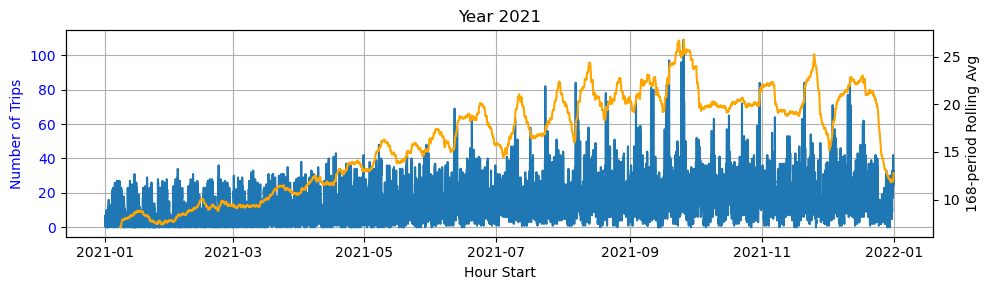

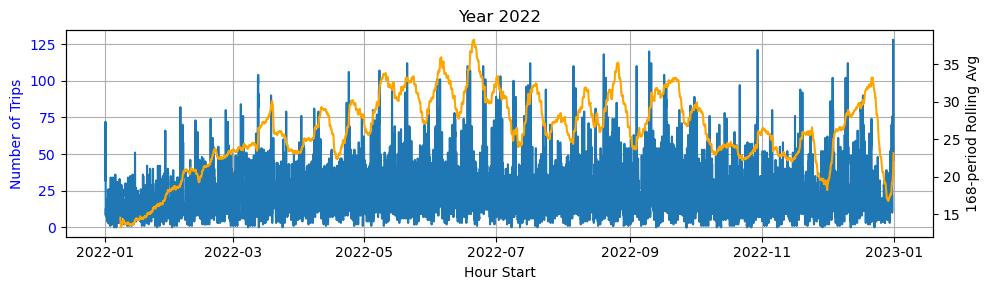

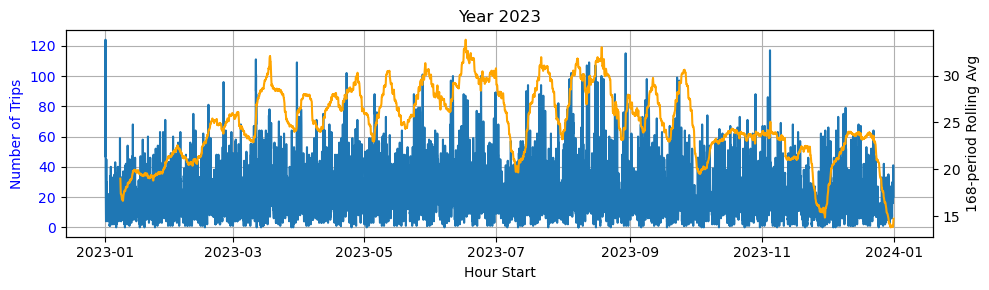

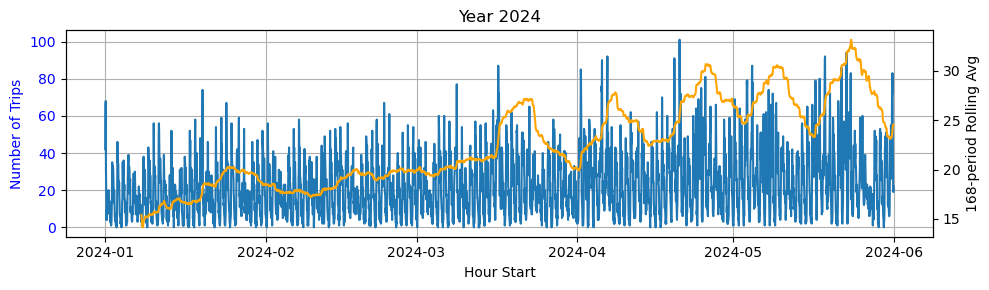

In [36]:
# Добавим столбец с годом
pandas_df['year'] = pandas_df['hour_start'].dt.year

# Получим уникальные годы
years = pandas_df['year'].unique()

# Создаем четыре отдельных графика для каждого года
for year in years:
    year_data = pandas_df[pandas_df['year'] == year]
    
    fig, ax1 = plt.subplots(figsize=(10, 3))
    
    # Построение графика для количества поездок
    ax1.plot(year_data['hour_start'], year_data['trips_p'], label='Number of Trips')
    ax1.set_xlabel('Hour Start')
    ax1.set_ylabel('Number of Trips', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)
    
    # Вычисление и построение 168-периодной скользящей средней на правой оси Y
    rolling_avg = year_data['trips_p'].rolling(window=168).mean()
    ax2 = ax1.twinx()
    ax2.plot(year_data['hour_start'], rolling_avg, label='168-period Rolling Avg', color='orange')
    ax2.set_ylabel('168-period Rolling Avg')
    ax2.tick_params(axis='y')
    
    plt.title(f'Year {year}')
    plt.tight_layout()
    plt.show()

На данной выборке можно увидеть, что годовая сезонность выражена паттернами:
- с начала года до примерно апреля наблюдается почти равномерный рост,
- есть пик в начале апреля
- с апреля по июль - "пила" - внутримесячная сезонность
- июль - "впадина"
- с июля по октябрь - "пила"
- ноябрь-декабрь "впадина"(минимум)-"пик"-"впадина"

In [37]:
# Функция для "красивой отрисовки" графика
def paint(h,date_begin,date_end,div,fields_list):
#     h           - датафрейм
#     date_begin  - дата-время начала окна данных
#     date_end    - дата-время конца окна
#     div         - делитель нацело для 24 для меток данных и сетки
#     fields_list - список полей значений для отрисовки
    # выбор периода и поля для отрисовки
    h_period = h[date_begin:date_end]
    # создание "двухэтажных" меток оси X
    xticklabels = [f"{h_period.index[i].strftime('%a')}\n---\n {hour}" 
                   if (i%12 == 0 and h_period.index[i].strftime('%H:%M') == '00:00') 
                   else (f"\n---\n{hour}" if i%div == 0 else "") 
                   for i, (dow, hour) in enumerate(zip(h_period['dow'], h_period.index.strftime('%H')))]
    # отрисовка графика
    fig, ax = plt.subplots(figsize=(10, 4))
    for field in fields_list:
        ax.plot(h_period.index, h_period[field], label=field)
        # ax.plot(h_period.index, h_period['sum_roll_12'], color='orange', label='sum_roll_12')
    ax.set_xticks(h_period.index)
    ax.set_xticklabels(xticklabels, fontsize=8)
    # нарисуем вертикальные линиии
    for i, (dow, hour) in enumerate(zip(h_period['dow'], h_period.index.strftime('%H'))):
        if i % div == 0:
            ax.axvline(h_period.index[i], linestyle=':', color='gray', alpha=0.5)
    ax.set_xlabel('Day of Week / Hour', labelpad=20)
    ax.xaxis.set_label_coords(0.5, -0.2)
    # ax.set_ylabel('sum_roll_6 / sum_roll_12 / sum')
    ax.legend()
    plt.show()

In [38]:
fields_list = ['trips_p']

In [39]:
pandas_df = pandas_df.set_index('hour_start')

In [40]:
pandas_df['dow'] = pandas_df.index.dayofweek

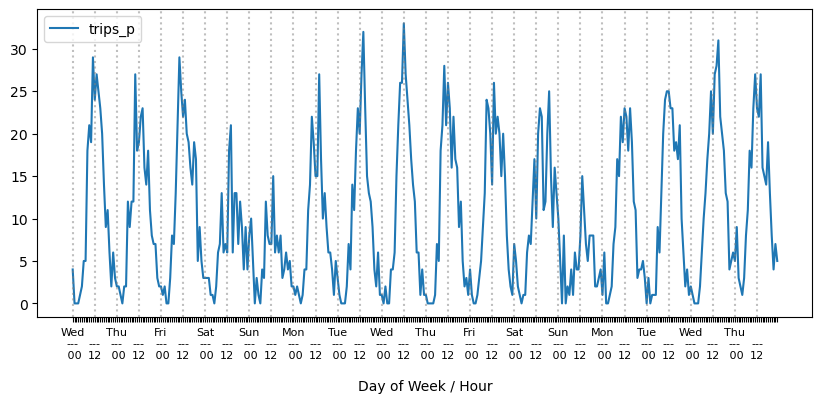

In [41]:
paint(pandas_df,'2021-03-03','2021-03-18',12,fields_list)

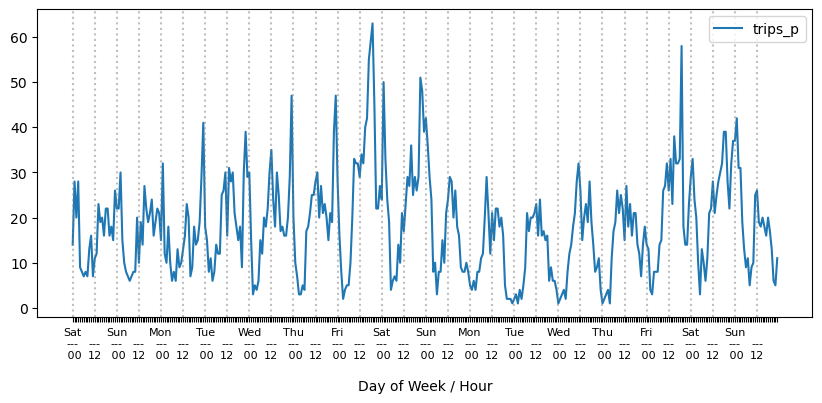

In [42]:
paint(pandas_df,'2021-07-03','2021-07-18',12,fields_list)

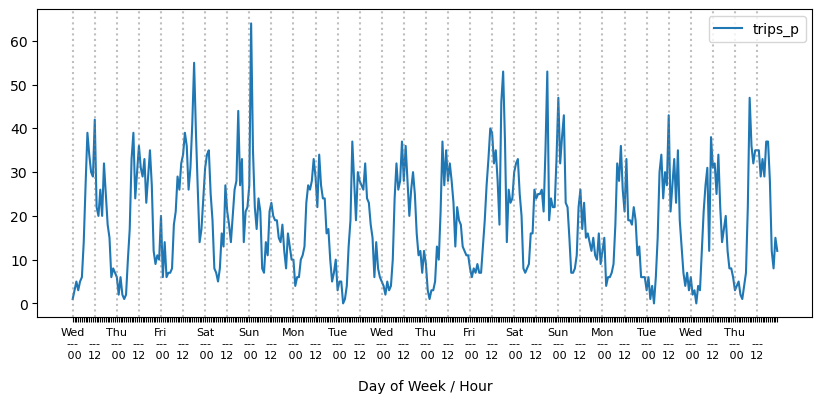

In [43]:
paint(pandas_df,'2021-11-03','2021-11-18',12,fields_list)

Очевидно, имеем дело с регулярными временными рядами и с ярко выраженной внутринедельной частотностью

### Посчитаем частоты

In [44]:
# Получение уникальных комбинаций районов и округов
unique_combinations = agg_hour.select('ct', 'ca').distinct().collect()

In [45]:
# Функция для вычисления частот для заданного района и округа
def compute_frequencies(ct, ca, spark_df):
    # Фильтрация данных для текущего района и округа
    filtered_spark_df = spark_df.filter((f.col('ct') == ct) & (f.col('ca') == ca))
    
    # Преобразование в Pandas DataFrame для работы с scipy
    filtered_pandas_df = filtered_spark_df.toPandas()
    
    # Если данных недостаточно, возвращаем пустой результат
    if len(filtered_pandas_df) < 4:
        return None
    
    # Вычисление частоты дискретизации
    fs = 1 / pd.Timedelta("1 hour").total_seconds()
    
    # Вычисление периодограммы
    frequencies, Pxx = welch(filtered_pandas_df['trips_p'].values, fs=fs, nperseg=len(filtered_pandas_df) // 4)
    
    # Получение индексов 10 наибольших пиков
    peak_indices = np.argsort(Pxx)[-10:]
    
    # Формирование словаря частот
    frequency_dict = {}
    for index in peak_indices:
        peak_frequency = frequencies[index]
        if peak_frequency == 0:
            continue  # Пропуск частоты 0, чтобы избежать деления на 0
        peak_period = 1 / peak_frequency
        hours_between_cycles = round(peak_period / 3600)
        if hours_between_cycles in frequency_dict:
            frequency_dict[hours_between_cycles] += 1
        else:
            frequency_dict[hours_between_cycles] = 1
    
    return {'ct': ct, 'ca': ca, 'frequency_dict': frequency_dict}

In [46]:
warnings.filterwarnings("ignore")

In [47]:
# Вычисление частот для всех районов и округов
results = []
for row in tqdm(unique_combinations):
    ct = row['ct']
    ca = row['ca']
    frequency_dict = compute_frequencies(ct, ca, agg_hour)
    if frequency_dict is not None:
        results.append(frequency_dict)

100%|██████████| 103/103 [10:17<00:00,  6.00s/it]


In [122]:
# Преобразование результатов в Pandas DataFrame
results_df = pd.DataFrame(results)

In [123]:
# Создаем пустой DataFrame для итогового результата
final_df = pd.DataFrame()

# Проходим по каждой строке в исходном DataFrame
for index, row in tqdm(results_df.iterrows(), total=len(results_df)):
    ct = row['ct']
    ca = row['ca']
    frequency_dict = row['frequency_dict']
    
    # Создаем новую строку для итогового DataFrame
    new_row = {'ct': ct, 'ca': ca}
    
    # Добавляем столбцы для каждой частоты из словаря
    for frequency, count in frequency_dict.items():
        new_row[frequency] = count
    
    # Преобразуем новую строку в DataFrame и добавляем к итоговому DataFrame
    new_df_row = pd.DataFrame([new_row])
    final_df = pd.concat([final_df, new_df_row], ignore_index=True)

100%|██████████| 103/103 [00:02<00:00, 51.11it/s]


In [124]:
# Определяем функцию для сортировки столбцов по возрастанию числовых значений
def sort_columns(df):
    # Получаем список всех столбцов, кроме 'ct' и 'ca', которые можно преобразовать в числа
    numeric_columns = [col for col in df.columns if col not in ['ct', 'ca']]
    # Фильтруем только те столбцы, которые можно преобразовать в int
    # numeric_columns = [col for col in numeric_columns if pd.to_numeric(df[col], errors='coerce').notnull().all()]
    # Сортируем столбцы по их целочисленным значениям
    sorted_columns = sorted(numeric_columns, key=lambda x: int(x))
    sorted_columns = ['ct', 'ca'] + sorted_columns
    return sorted_columns
    
sorted_columns = sort_columns(final_df)

In [125]:
# Заполнение пропусков нулями
final_df_sorted = final_df.fillna(0)

# Вывод отсортированного и заполненного DataFrame
print(final_df_sorted[sorted_columns])

              ct  ca    2    3    4    5    6    8   12   13  ...  7461  7466  \
0    17031090200   6  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   0.0   0.0   
1    17031110200  15  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   
2    17031770700  90  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  ...   0.0   0.0   
3    12000000016  56  0.0  0.0  0.0  0.0  0.0  1.0  2.0  0.0  ...   0.0   0.0   
4    17031400400  51  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  ...   0.0   0.0   
..           ...  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
98   12000000005  62  2.0  1.0  1.0  1.0  2.0  1.0  0.0  0.0  ...   0.0   0.0   
99   12000000040  20  1.0  1.0  1.0  0.0  0.0  2.0  2.0  0.0  ...   0.0   0.0   
100  12000000009  35  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  ...   0.0   0.0   
101  12000000015  67  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  ...   0.0   0.0   
102  12000000021  21  0.0  0.0  0.0  0.0  0.0  1.0  2.0  0.0  ...   0.0   0.0   

     7471  7472  7477  7478

In [126]:
" ".join([str(item) for item in sorted_columns])

'ct ca 2 3 4 5 6 8 12 13 21 24 28 34 42 56 83 84 165 166 168 169 170 265 267 297 309 440 467 1064 1491 1870 2494 3685 3712 3714 3727 3730 3736 3738 3739 3740 3741 7370 7371 7423 7429 7447 7454 7460 7461 7466 7471 7472 7477 7478 7479 7480 7481 7482'

In [127]:
selected_df = final_df_sorted[sorted_columns]
sums_dict = {str(col): selected_df[col].sum() for col in selected_df.columns}
sums_dict

{'ct': 1515756344696,
 'ca': 3730,
 '2': 6.0,
 '3': 16.0,
 '4': 8.0,
 '5': 14.0,
 '6': 22.0,
 '8': 65.0,
 '12': 150.0,
 '13': 4.0,
 '21': 24.0,
 '24': 341,
 '28': 110.0,
 '34': 14.0,
 '42': 1.0,
 '56': 2.0,
 '83': 1.0,
 '84': 16.0,
 '165': 3.0,
 '166': 69.0,
 '168': 2.0,
 '169': 5.0,
 '170': 60.0,
 '265': 1.0,
 '267': 3.0,
 '297': 1.0,
 '309': 1.0,
 '440': 1.0,
 '467': 2.0,
 '1064': 1.0,
 '1491': 1.0,
 '1870': 1.0,
 '2494': 1.0,
 '3685': 1.0,
 '3712': 1.0,
 '3714': 1.0,
 '3727': 1.0,
 '3730': 1.0,
 '3736': 3.0,
 '3738': 2.0,
 '3739': 1.0,
 '3740': 12.0,
 '3741': 3.0,
 '7370': 1.0,
 '7371': 1.0,
 '7423': 1.0,
 '7429': 1.0,
 '7447': 1.0,
 '7454': 2.0,
 '7460': 2.0,
 '7461': 1.0,
 '7466': 1.0,
 '7471': 1.0,
 '7472': 2.0,
 '7477': 2.0,
 '7478': 3.0,
 '7479': 8.0,
 '7480': 8.0,
 '7481': 11.0,
 '7482': 8.0}

In [128]:
168/24, 84/24, 24/24, 28/24, 12/24, 8/24

(7.0, 3.5, 1.0, 1.1666666666666667, 0.5, 0.3333333333333333)

Получили наиболее значимые частоты.

В рамках данного исследования (по крайней мере на данной итерации) не буду делать следующие вещи:
- использовать способ с использованием пандас ЮДФ для расчета частот
- выделять сезонности и тренд на трэйне и растягивать полученный результат на тест
- генерить разные сложносочиненные фичи на основе метки времени, включая простое выделение номеров месяца и недели

Ограничусь созданием лагов и скользящих средних по выделенным значимым частотам. Также для определения внутринедельного и внутрисезонного трендов добавлю прирост скользящих к предыдущему периоду.

Перед генерацией лаговых признаков сдвигать целевое поле на 1 период вперед не требуется. Но потребуется сдвинуть его назад для формирования целевой переменной (т.е. в каждый час мы прогнозируем значение на предстоящий час, соответственно это значение часа из будущего у нас должно быть в качестве метки)

## Сгенерируем лаги

In [72]:
# Сдвинем значения полей trips_p на n интервалов
# И посчитаем скользящие средние
shift_periods = [
    168, 84, 24, 28, 12, 8, 4
]

window_ct_ca = Window.partitionBy("ct", "ca").orderBy("hour_start")

for period in shift_periods:
    window_ma = Window.partitionBy("ct", "ca").orderBy("hour_start").rowsBetween(-period+1, 0)
    field_sh = f"trips_sh_{period}"
    field_ma = f"trips_ma_{period}"
    agg_hour = agg_hour\
    .withColumn(
        field_sh, f.lag(f.col('trips_p'), period).over(window_ct_ca)
    )\
    .withColumn(
        field_ma, f.avg(f.col("trips_p")).over(window_ma)
    )

In [73]:
f_to_sel = [
    'ct','ca','hour_start','trips_p',
    'trips_sh_4', 'trips_sh_8',
    'trips_ma_4', 'trips_ma_8',
]

In [74]:
agg_sample = agg_hour.select(*f_to_sel).filter(f.col('ct')==17031090200)
agg_sample.show(10)
agg_sample.cache()

+-----------+---+-------------------+-------+----------+----------+------------------+------------------+
|         ct| ca|         hour_start|trips_p|trips_sh_4|trips_sh_8|        trips_ma_4|        trips_ma_8|
+-----------+---+-------------------+-------+----------+----------+------------------+------------------+
|17031090200|  6|2021-01-01 01:00:00|      1|      null|      null|               1.0|               1.0|
|17031090200|  6|2021-01-01 02:00:00|      7|      null|      null|               4.0|               4.0|
|17031090200|  6|2021-01-01 03:00:00|      2|      null|      null|3.3333333333333335|3.3333333333333335|
|17031090200|  6|2021-01-01 04:00:00|      2|      null|      null|               3.0|               3.0|
|17031090200|  6|2021-01-01 05:00:00|      0|         1|      null|              2.75|               2.4|
|17031090200|  6|2021-01-01 06:00:00|      0|         7|      null|               1.0|               2.0|
|17031090200|  6|2021-01-01 07:00:00|      5| 

DataFrame[ct: bigint, ca: int, hour_start: timestamp, trips_p: int, trips_sh_4: int, trips_sh_8: int, trips_ma_4: double, trips_ma_8: double]

Сдвинуто и посчитано правильно.  
Сдвину скользящие средние и посчитаю разницу между текущим значением МА и лагом в 2 периода (для коротких скользящих 4 и 8 периодные), и разницу с лагом в 168 периодов для недельной скользящей. Посчитаю темп прироста скользящих.

In [79]:
shift_periods = [
    168, 8, 4
]

window_ct_ca = Window.partitionBy("ct", "ca").orderBy("hour_start")

drop_cols = []

for period in shift_periods:
    # drop_cols = []
    window_ma = Window.partitionBy("ct", "ca").orderBy("hour_start").rowsBetween(-period+1, 0)
    field_ma = f"trips_ma_{period}"
    if period == 168:
        shift = 168
    else: shift = 2
    field_ma_sh = f"{field_ma}_sh_{shift}"
    drop_cols.append(field_ma_sh)
    field_ma_growth = f"{field_ma}_growth"
    agg_hour = agg_hour\
    .withColumn(
        field_ma_sh, f.lag(f.col(field_ma), shift).over(window_ct_ca)
    )\
    .withColumn(
        field_ma_growth, f.when((f.col(field_ma) != 0),
                      1 - (f.col(field_ma_sh) / f.col(field_ma)))
                           .otherwise(0))

In [80]:
drop_cols

['trips_ma_168_sh_168', 'trips_ma_8_sh_2', 'trips_ma_4_sh_2']

In [84]:
f_to_sel = [
    'ct','ca','hour_start','trips_p',
    'trips_ma_4', 'trips_ma_168',
    'trips_ma_4_growth', 'trips_ma_168_growth',
]+drop_cols
agg_sample = agg_hour.select(*f_to_sel).filter(f.col('ct')==17031090200)
agg_sample.select(
    'hour_start','trips_p',
    'trips_ma_4','trips_ma_4_sh_2','trips_ma_4_growth',
    'trips_ma_168','trips_ma_168_sh_168','trips_ma_168_growth'
).filter(f.col('trips_ma_168_sh_168').isNotNull()).show(10)
agg_sample.cache()

+-------------------+-------+----------+---------------+-------------------+-----------------+-------------------+-------------------+
|         hour_start|trips_p|trips_ma_4|trips_ma_4_sh_2|  trips_ma_4_growth|     trips_ma_168|trips_ma_168_sh_168|trips_ma_168_growth|
+-------------------+-------+----------+---------------+-------------------+-----------------+-------------------+-------------------+
|2021-01-08 01:00:00|      0|       0.5|           1.75|               -2.5|7.148809523809524|                1.0| 0.8601165695253955|
|2021-01-08 02:00:00|      1|       0.5|            1.0|               -1.0|7.113095238095238|                4.0|0.43765690376569033|
|2021-01-08 03:00:00|      2|      0.75|            0.5|0.33333333333333337|7.113095238095238| 3.3333333333333335| 0.5313807531380753|
|2021-01-08 04:00:00|      1|       1.0|            0.5|                0.5|7.107142857142857|                3.0| 0.5778894472361809|
|2021-01-08 05:00:00|      3|      1.75|           0.75

DataFrame[ct: bigint, ca: int, hour_start: timestamp, trips_p: int, trips_ma_4: double, trips_ma_168: double, trips_ma_4_growth: double, trips_ma_168_growth: double, trips_ma_168_sh_168: double, trips_ma_8_sh_2: double, trips_ma_4_sh_2: double]

Сдвинуть и посчитано правильно.  
Удалю поля со сдвинутыми машками и удалю образовавшиеся пропуски

In [85]:
agg_hour = agg_hour.drop(*drop_cols).dropna()
print(pds.gvf(agg_hour.count()))
agg_hour.cache()

3'062'146


DataFrame[ct: bigint, ca: int, hour_start: timestamp, trips_p: int, time_p: int, miles_p: double, velocity_p: double, farem_p: double, tipsm_p: double, tollsm_p: double, extrasm_p: double, totalm_p: double, comp1_p: int, comp2_p: int, comp3_p: int, comp4_p: int, comp5_p: int, compless5_p: int, trips_d: int, time_d: int, miles_d: double, velocity_d: double, farem_d: double, tipsm_d: double, tollsm_d: double, extrasm_d: double, totalm_d: double, comp1_d: int, comp2_d: int, comp3_d: int, comp4_d: int, comp5_d: int, compless5_d: int, cumulative_balance: int, trips_p_growth_1_to_0: double, trips_p_growth_2_to_1: double, trips_p_growth_3_to_2: double, trips_p_growth_4_to_3: double, trips_d_growth_1_to_0: double, trips_d_growth_2_to_1: double, trips_d_growth_3_to_2: double, trips_d_growth_4_to_3: double, velocity_p_growth_1_to_0: double, velocity_p_growth_2_to_1: double, velocity_p_growth_3_to_2: double, velocity_p_growth_4_to_3: double, velocity_d_growth_1_to_0: double, velocity_d_growth_2_t

Сдвинем метку

In [86]:
# Сдвинем значения полей interend trips_p на 1 интервал назад
fields_to_shift = [
    'trips_p'
]

for field in fields_to_shift:
    agg_hour = agg_hour.withColumn(
        'trips_target', f.lead(f.col(field), 1).over(window_ct_ca)
    )

In [87]:
f_to_sel = [
    'ct', 'ca', 'hour_start', 'trips_p', 'trips_target'
]

agg_sample = agg_hour.select(*f_to_sel).filter(f.col('ct')==17031090200)
agg_sample.show(5)
agg_sample.cache()

+-----------+---+-------------------+-------+------------+
|         ct| ca|         hour_start|trips_p|trips_target|
+-----------+---+-------------------+-------+------------+
|17031090200|  6|2021-01-08 01:00:00|      0|           1|
|17031090200|  6|2021-01-08 02:00:00|      1|           2|
|17031090200|  6|2021-01-08 03:00:00|      2|           1|
|17031090200|  6|2021-01-08 04:00:00|      1|           3|
|17031090200|  6|2021-01-08 05:00:00|      3|           5|
+-----------+---+-------------------+-------+------------+
only showing top 5 rows



DataFrame[ct: bigint, ca: int, hour_start: timestamp, trips_p: int, trips_target: int]

Сдвинуто правильно. Удалим поле 'trips_p' и удалим пропуски

In [88]:
agg_hour = agg_hour.drop('trips_p')
agg_hour = agg_hour.dropna()

Сохраню датафрейм в файл.

## Агг 1ч итог - сохранение

In [89]:
%%time
agg_hour.coalesce(1).write.csv("/work/data/taxis_agg_hour_result.csv", header=True, mode="overwrite")

CPU times: user 48.1 ms, sys: 10.2 ms, total: 58.3 ms
Wall time: 3min 17s


In [90]:
%%time
data = spark.read.load('/work/data/taxis_agg_hour_result.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 110 ms, sys: 50.8 ms, total: 161 ms
Wall time: 1min 29s


## AGGFE Fin

На этом агрегация данных и конструирование признаков завершены.  
Моделирование и прогнозирование поездок по районам (округам) и часам - в другом ноутбуке.  

Остановим Спарк-сессии.

In [91]:
spark_app.stop_spark_app()

INFO:spark_app:attempt to stop SparkSession app object
INFO:spark_app:.stop() instruction has been executed
INFO:spark_app:attempt to create new SparkSession app object after stopping


'stopped'